# Diviser dataset annoté en train/val/test

## Imports

In [1]:
import os
import re
import datetime

from cairosvg import svg2png
from IPython.display import display, SVG
from PIL import Image



## Variables

In [10]:
todays_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

GRAPHICS_BASE_PATH = "data/notebook_99/graphics"
GRAPHICS_PATH = os.path.join(GRAPHICS_BASE_PATH, todays_date)
os.makedirs(GRAPHICS_PATH, exist_ok=True)

TILE_1024_FOLDER_PATH = "data/notebook_04/geotiff/tile_1024_split"
GEOTIFF_ORTHO2019_PATH = "data/SITG/ortho2019"

#------------------------------------
# Noms des images
# -----------------------------------

# Schéma principal machine learning supervisé
ML_WORKFLOW_PNG = "01_ML_workflow.png"

# Classification
CLASSIFICATION_WORKFLOW_PNG = "ch3_piste_exploree_classification_01_workflow.png"

# ETL données
ETL_WORKFLOW_PNG = "ch3_preparation_donnees_01_etl.png"

# orthophotos 
ETL_ORTHOPHOTOS_PNG = "ch3_preparation_donnees_orthophotos_01_etl.png"
EXEMPLE_DECOUPE_ORTHOPHOTO_01_PNG = "ch3_preparation_donnees_orthophotos_02_exemple_decoupe_orthophoto1.png"
EXEMPLE_DECOUPE_ORTHOPHOTO_02_PNG = "ch3_preparation_donnees_orthophotos_03_exemple_decoupe_orthophoto2.png"
EXEMPLE_DECOUPE_ORTHOPHOTO_03_PNG = "ch3_preparation_donnees_orthophotos_04_exemple_decoupe_orthophoto3.png"
EXEMPLE_DECOUPE_ORTHOPHOTO_04_PNG = "ch3_preparation_donnees_orthophotos_05_exemple_decoupe_orthophoto4.png"
EXEMPLE_DECOUPE_ORTHOPHOTO_05_PNG = "ch3_preparation_donnees_orthophotos_06_exemple_decoupe_orthophoto5.png"
EXEMPLE_DECOUPE_ORTHOPHOTO_06_PNG = "ch3_preparation_donnees_orthophotos_07_exemple_decoupe_orthophoto6.png"

# post-traitement dataset
POST_TREATMENT_DATASET_01_OVERVIEW_PNG = "ch3_postprocessing_dataset_03_overview.png"

# entrainement modèle
ARCHITECTURE_SIZE_DECODER_PNG = "ch36_architecture_02_architecture_taille_decodeur.png"
BACKBONE_SIZE_ENCODER_FAMILY_PNG = "ch36_architecture_03_backbone_taille_encodeur_famille.png"
BACKBONE_SIZE_ENCODER_ORDER_PNG = "ch36_architecture_04_backbone_taille_encodeur_ordonnee.png"

## helpers

In [ ]:
def save_svg_as_png(svg_content, filename, dpi=2400, scale=4.0):
    """
    Convert SVG content to a high-resolution PNG file.

    Args:
        svg_content (str): SVG content as a string.
        filename (str): Output filename for the PNG file.
        dpi (int): Output resolution in dots per inch.
        scale (float): Additional scaling factor for the output image.
    """
    # Try to extract width and height from the SVG string
    width_match = re.search(r'width="([^"]*)"', svg_content)
    height_match = re.search(r'height="([^"]*)"', svg_content)

    if width_match and height_match:
        # Remove units and convert to float
        width = float(re.sub(r'[^\d.]', '', width_match.group(1)))
        height = float(re.sub(r'[^\d.]', '', height_match.group(1)))

        # Calculate output dimensions using scale
        output_width = int(width * scale)
        output_height = int(height * scale)

        # Convert SVG to PNG with specified dimensions and DPI
        svg2png(
            bytestring=svg_content.encode('utf-8'),
            write_to=filename,
            output_width=output_width,
            output_height=output_height,
            dpi=dpi
        )
    else:
        print("Warning: Could not determine SVG width and height. Using default scale and DPI.")
        # Fallback: use scale and DPI only
        svg2png(
            bytestring=svg_content.encode('utf-8'),
            write_to=filename,
            scale=scale,
            dpi=dpi
        )

    # Display the SVG in the notebook
    display(SVG(svg_content))

    print(f"High-resolution PNG saved to {filename} (DPI: {dpi}, Scale: {scale}x)")


In [ ]:
def save_high_quality_kroki(img_obj, filename):
    """
    Save an IPython Image object (such as from kroki diagrams) to a file.

    Args:
        img_obj: IPython Image object containing PNG data.
        filename (str): Path to save the PNG file.
    """
    # Attempt to extract binary PNG data from the image object
    binary_data = None

    if hasattr(img_obj, 'data') and img_obj.data:
        binary_data = img_obj.data
    elif hasattr(img_obj, '_repr_png_') and img_obj._repr_png_():
        binary_data = img_obj._repr_png_()
    elif hasattr(img_obj, '_data') and img_obj._data:
        binary_data = img_obj._data
    else:
        # Fallback: search for any attribute containing binary data
        for attr_name in dir(img_obj):
            if not attr_name.startswith('__'):
                attr_value = getattr(img_obj, attr_name)
                if isinstance(attr_value, bytes) and len(attr_value) > 1000:
                    binary_data = attr_value
                    break

    if binary_data:
        with open(filename, 'wb') as f:
            f.write(binary_data)

        file_size = os.path.getsize(filename)

        # Format file size for display
        if file_size < 1024:
            size_str = f"{file_size} B"
        elif file_size < 1024**2:
            size_str = f"{file_size/1024:.1f} KB"
        elif file_size < 1024**3:
            size_str = f"{file_size/(1024**2):.1f} MB"
        else:
            size_str = f"{file_size/(1024**3):.1f} GB"

        # Attempt to get image dimensions
        try:
            from PIL import Image
            with Image.open(filename) as img:
                width, height = img.size
                dimensions = f"{width}x{height}"
        except ImportError:
            dimensions = "dimensions unknown (PIL not available)"
        except Exception:
            dimensions = "dimensions unknown"

        print(f"PNG saved: {filename} ({size_str}, {dimensions})")
    else:
        available_attrs = [attr for attr in dir(img_obj) if not attr.startswith('__')]
        print(f"No binary data found. Available attributes: {available_attrs}")

## Schéma machine learning

In [5]:
from kroki import diagram_image

graphviz_code = '''
digraph MLWorkflow {
    rankdir=TB;
    ranksep="0.5 equally";
    nodesep=0.5;
    dpi=300;
    
    graph [splines=ortho];
    edge [color="#2E86AB", penwidth=1.5, arrowsize=0.6];
    
    // Define base style
    node [shape=box, style="rounded,filled", fontname="Arial", fontsize=11,
          height=0.65, width=1.5, fixedsize=true];
    
    // Planning style - Blue theme
    A [label=<<FONT POINT-SIZE="14">①</FONT><BR/>Définition de la tâche>, 
       fillcolor="#e3f2fd", color="#1976d2", penwidth=1];
    B [label=<<FONT POINT-SIZE="14">②</FONT><BR/>Choix algorithme>, 
       fillcolor="#e3f2fd", color="#1976d2", penwidth=1];
    
    // Data preparation style - Green theme
    C [label=<<FONT POINT-SIZE="14">③</FONT><BR/>Sélection données>, 
       fillcolor="#e8f5e8", color="#388e3c", penwidth=1];
    D [label=<<FONT POINT-SIZE="14">④</FONT><BR/>Labellisation>, 
       fillcolor="#e8f5e8", color="#388e3c", penwidth=1];
    E [label=<<FONT POINT-SIZE="14">⑤</FONT><BR/>Datasets>, 
       fillcolor="#e8f5e8", color="#388e3c", penwidth=1];
    
    // Training style - Orange theme
    F [label=<<FONT POINT-SIZE="14">⑥</FONT><BR/>Entraînement>, 
       fillcolor="#fff3e0", color="#f57c00", penwidth=1];
    G [label=<<FONT POINT-SIZE="14">⑦</FONT><BR/>Validation>, 
       fillcolor="#fff3e0", color="#f57c00", penwidth=1];
    H [label=<<FONT POINT-SIZE="14">⑧</FONT><BR/>Test>, 
       fillcolor="#fff3e0", color="#f57c00", penwidth=1];
    
    // Production style - Purple theme
    I [label=<<FONT POINT-SIZE="14">⑨</FONT><BR/>Production>, 
       fillcolor="#f3e5f5", color="#7b1fa2", penwidth=2];
    
    // Control horizontal positioning
    {rank=same; A, B}
    B -> A [dir=back];
    
    {rank=same; C, D, E}
    C -> D -> E;
    
    {rank=same; H, G, F}
    H -> G -> F [dir=back];
    
    {rank=same; I}
    
    // Workflow edges
    B -> C [weight=1];
    E -> F [weight=1];
    H -> I [label=" OK", fontsize=10, fontcolor="darkgreen"];
    
    // Feedback loop
    H -> C [style="dashed", color="red", constraint=false, 
            taillabel="KO ", fontsize=10, fontcolor="red"];
    H -> F [style="dashed", color="red", constraint=false, 
            taillabel="KO ", fontsize=10, fontcolor="red"];
}
'''

png_data = diagram_image(graphviz_code, diagram_type='graphviz', output_format='png')

# write to file
save_high_quality_kroki(png_data, os.path.join(GRAPHICS_PATH, ML_WORKFLOW_PNG))

# display(png_data)

PNG saved: data/notebook_99/graphics/20250626-180244/01_ML_workflow.png (116.5 KB, 1983x1423)


## Classification

In [6]:
from kroki import diagram_image

graphviz_code = '''
    digraph RoofClassification {
        rankdir=TB;
        bgcolor=transparent;
        fontname="Arial";
        pad="1.0";
        nodesep="0.2";        // Reduced from 1.0 to 0.3 (less horizontal spacing)
        ranksep="0.4";        // Reduced from 0.8 to 0.6 (tighter vertical spacing)
        ratio=compress;
        dpi=300;
        size="8,12!";         // Limit width to 8 inches, height to 12 inches
        
        // Base node style - auto-sized to content with larger font
        node [shape=box, style="rounded,filled", fontname="Arial", fontsize=14,
              margin="0.15"];  // Increased fontsize from 10 to 14
        
        // Edge style with larger font for labels
        edge [color="#2E86AB", penwidth=1.5, arrowsize=0.6, fontsize=12];
        
        // Subgraph for classification section
        subgraph cluster_1 {
            label="2. Classification des Toitures";
            style=rounded;
            color="#2A4D7E";
            margin=20;
            fontsize=16;        // Increased cluster title font size
            fontname="Arial";
            
            // Process nodes - Green theme
            classify_start [label="Classification\\nToitures", 
                          fillcolor="#F1F8E9", color="#558B2F"];
            
            // Validation nodes - Orange theme (diamonds)
            surface_check [label="Surface > 2m²?", 
                          fillcolor="#FFF3E0", color="#EF6C00", shape=diamond];
            
            trou_check [label="Polygone toiture avec\\ntrou contenu dedans?", 
                       fillcolor="#FFF3E0", color="#EF6C00", shape=diamond];
            
            sp_check_avec_trou [label="Superstructure?", 
                              fillcolor="#FFF3E0", color="#EF6C00", shape=diamond];
            
            sp_check_sans_trou [label="Superstructure?", 
                              fillcolor="#FFF3E0", color="#EF6C00", shape=diamond];
            
            // Action nodes - Purple theme
            classe2a [label="Classe 2a\\nPartiellement occupée\\nPas de trou\\nSuperstructure", 
                     fillcolor="#E8EAF6", color="#3949AB"];
            
            classe2b [label="Classe 2b:\\nPartiellement occupée\\nTrou\\nSuperstructure", 
                     fillcolor="#E8EAF6", color="#3949AB"];
            
            classe3a [label="Classe 3a:\\nLibre\\nPas de trou\\nPas de superstructure", 
                     fillcolor="#E8EAF6", color="#3949AB"];
            
            classe3b [label="Classe 3b:\\nLibre\\nTrou\\nPas de superstructure", 
                     fillcolor="#E8EAF6", color="#3949AB"];
            
            // Action on image nodes - Red theme
            classe2a_sans_sp [label="Action sur image:\\nSupprimer SP\\nde l'image", 
                             fillcolor="#FFEBEE", color="#D32F2F"];
            
            classe2a_avec_sp [label="Pas d'action sur image", 
                             fillcolor="#FFEBEE", color="#D32F2F"];
            
            classe3b_sans_trou [label="Action sur image:\\nSupprimer trou\\nde l'image", 
                               fillcolor="#FFEBEE", color="#D32F2F"];
            
            classe3b_avec_trou [label="Pas d'action sur image", 
                               fillcolor="#FFEBEE", color="#D32F2F"];
            
            // Output files - Blue theme with bold border
            classe1 [label="Classe 1:\\nTotalement occupée", 
                    fillcolor="#E3F2FD", color="#1565C0", penwidth=2.5, style="rounded,filled,bold"];
            
            classe2 [label="Classe 2:\\nPartiellement occupée", 
                    fillcolor="#E3F2FD", color="#1565C0", penwidth=2.5, style="rounded,filled,bold"];
            
            classe3 [label="Classe 3:\\nLibre", 
                    fillcolor="#E3F2FD", color="#1565C0", penwidth=2.5, style="rounded,filled,bold"];
        }
        
        // Define ranking for better layout - stack more vertically
        {rank=source; classify_start, surface_check}
        {rank=same; trou_check}
        // Split the superstructure checks into separate ranks to reduce width
        {rank=same; sp_check_sans_trou}
        {rank=same; sp_check_avec_trou}
        // Stack classification nodes vertically instead of horizontally
        {rank=same; classe2a, classe3a}
        {rank=same; classe2b, classe3b}
        {rank=same; classe2a_sans_sp, classe2a_avec_sp}
        {rank=same; classe3b_sans_trou, classe3b_avec_trou}
        {rank=sink; classe1, classe2, classe3}
        
        // Flow edges
        classify_start -> surface_check;
        surface_check -> classe1 [label=" ≤ 2m²", fontsize=12];
        surface_check -> trou_check [label=" > 2m²", fontsize=12];
        trou_check -> sp_check_sans_trou [label=" Non", fontsize=12];
        trou_check -> sp_check_avec_trou [label=" Oui", fontsize=12];
        sp_check_avec_trou -> classe2b [label=" Oui", fontsize=12];
        sp_check_avec_trou -> classe3b [label=" Non", fontsize=12];
        sp_check_sans_trou -> classe2a [label=" Oui", fontsize=12];
        sp_check_sans_trou -> classe3a [label=" Non", fontsize=12];
        
        // Action connections
        classe2a -> classe2a_sans_sp;
        classe2a -> classe2a_avec_sp;
        classe3b -> classe3b_sans_trou;
        classe3b -> classe3b_avec_trou;
        
        // Final classification
        classe2a_sans_sp -> classe3;
        classe2a_avec_sp -> classe2;
        classe3b_sans_trou -> classe3;
        classe3b_avec_trou -> classe2;
        classe3a -> classe3;
        classe2b -> classe2;
    }
    '''

png_data = diagram_image(graphviz_code, diagram_type='graphviz', output_format='png')

# write to file
save_high_quality_kroki(png_data, os.path.join(GRAPHICS_PATH, CLASSIFICATION_WORKFLOW_PNG))

# display(png_data)


PNG saved: data/notebook_99/graphics/20250626-180244/ch3_piste_exploree_classification_01_workflow.png (369.4 KB, 2400x2196)


## ETL données

PNG saved: data/notebook_99/graphics/20250626-180244/ch3_preparation_donnees_01_etl.png (223.2 KB, 2105x2400)


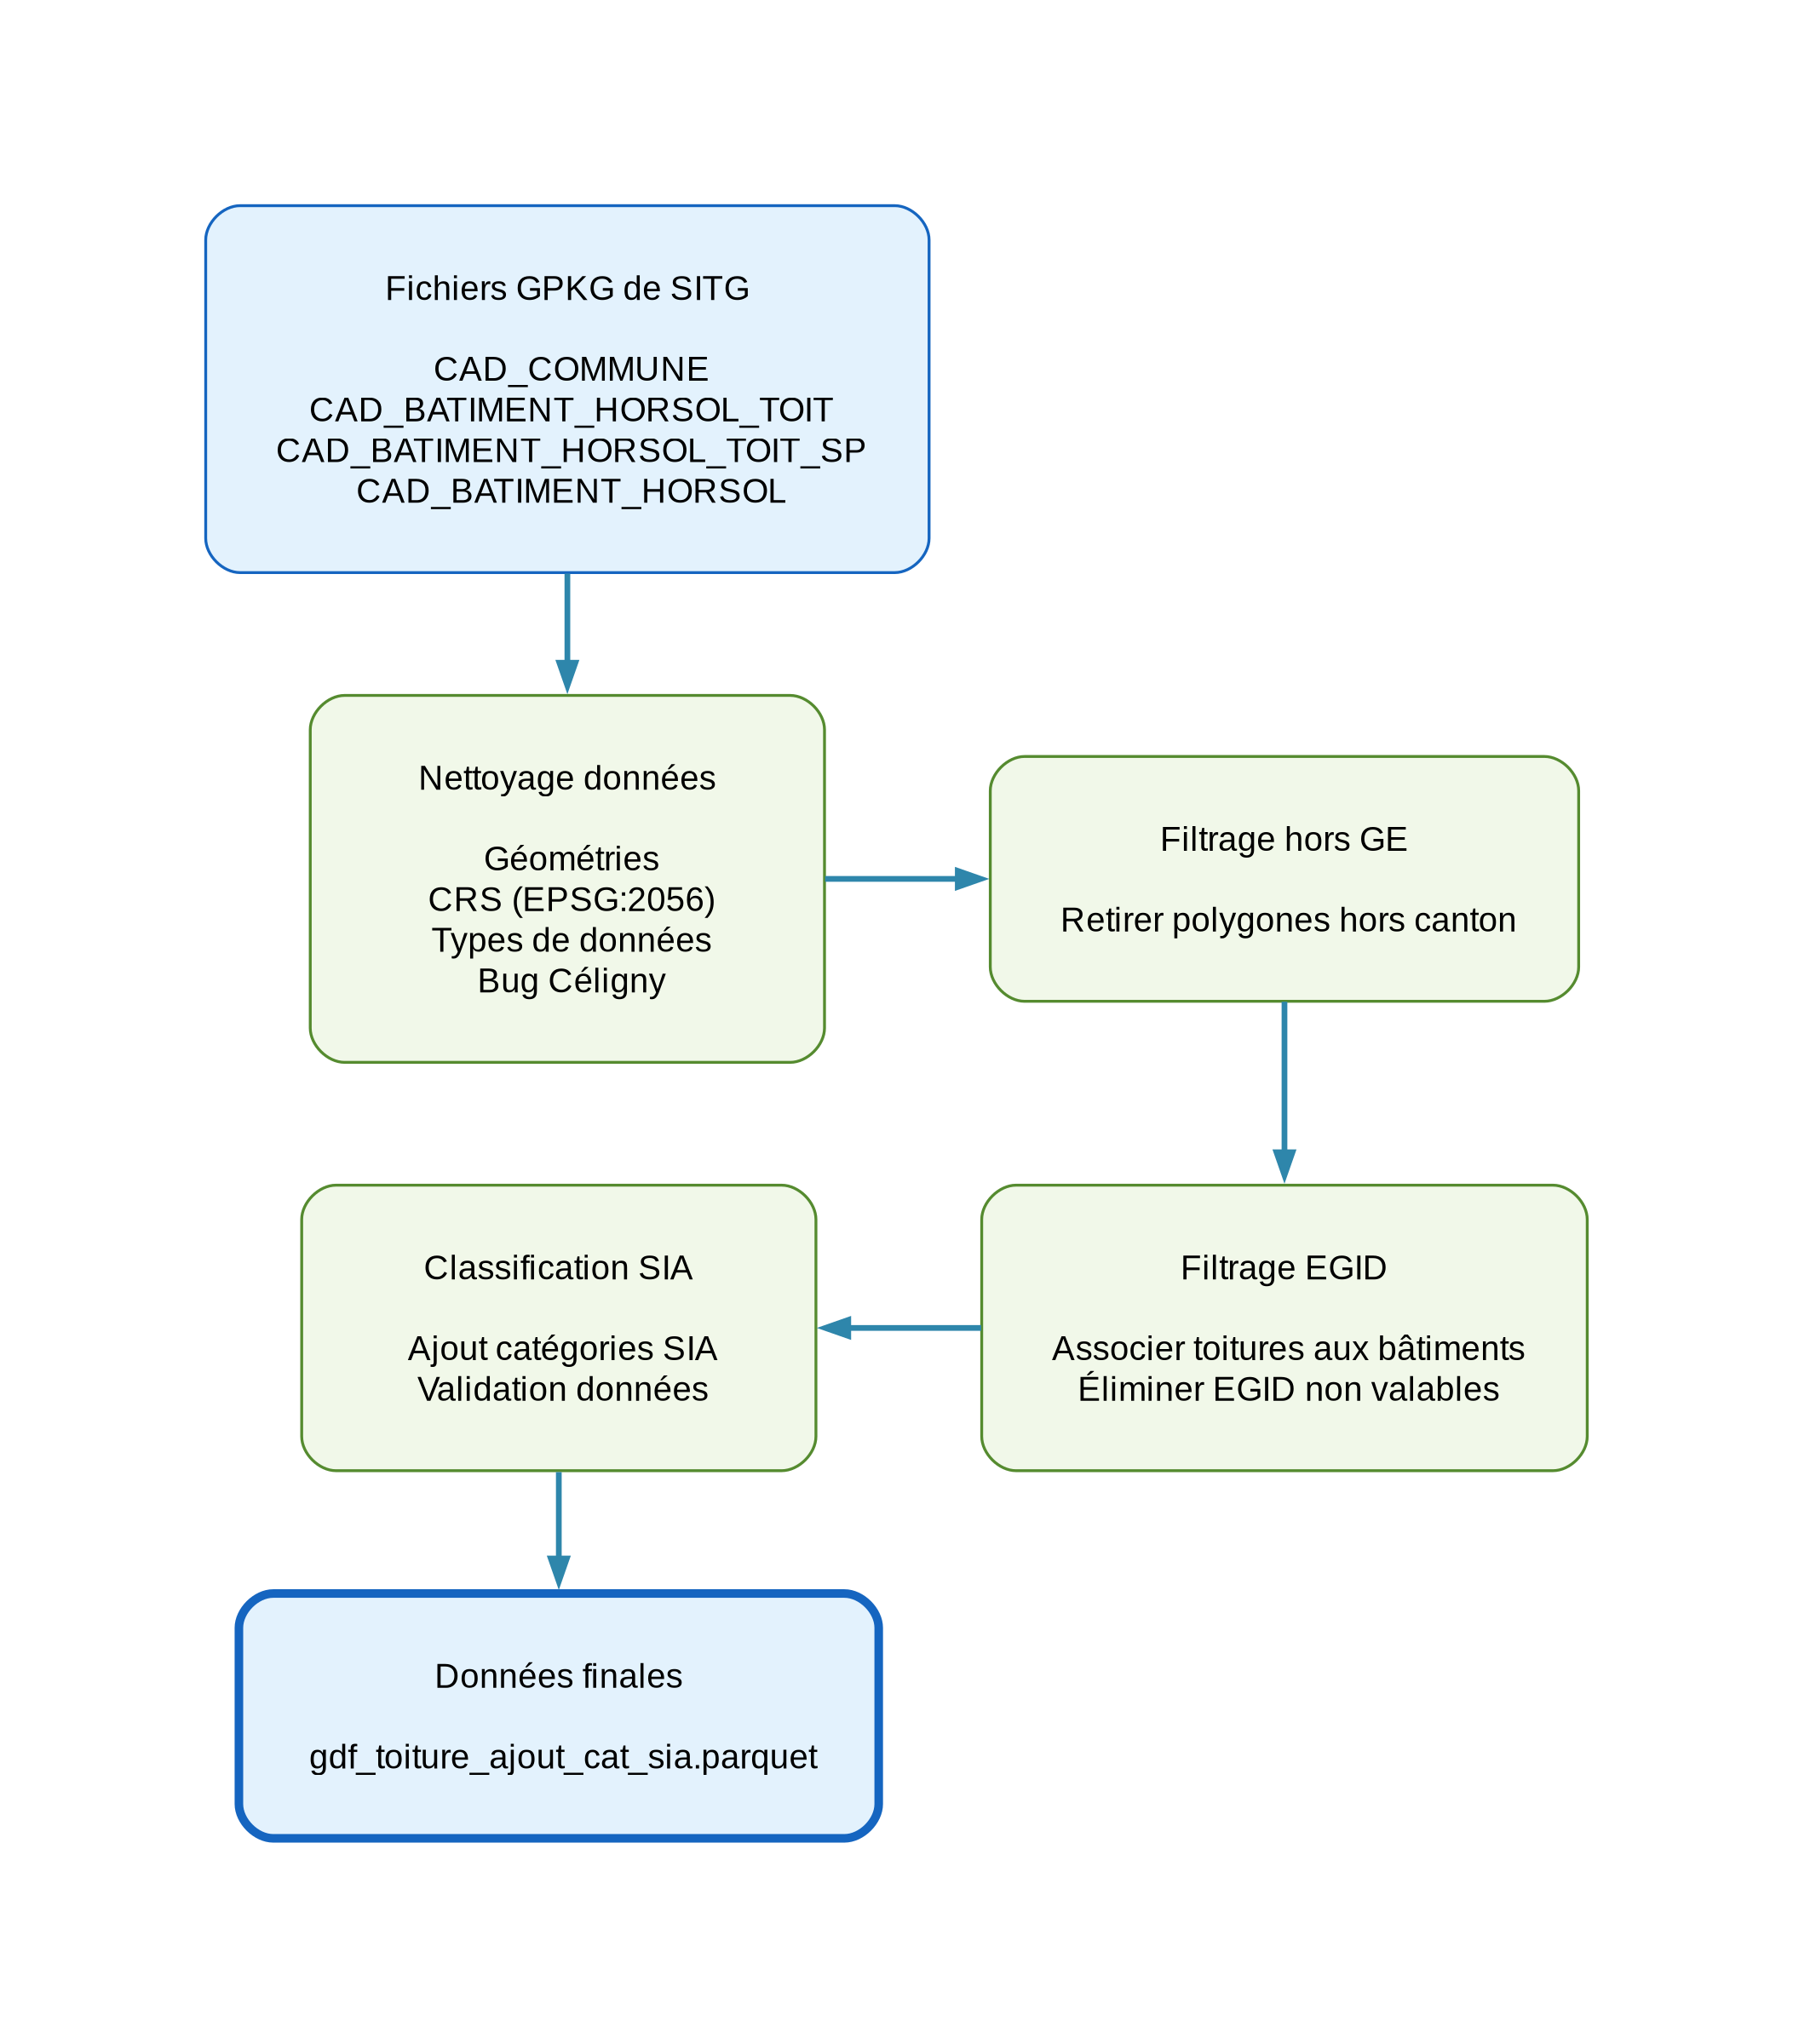

In [7]:
from kroki import diagram_image

graphviz_code = '''
    digraph SimplifiedDataFlow {
        rankdir=TB;
        bgcolor=transparent;
        fontname="Arial";
        pad="1.0";
        nodesep="0.8";
        ranksep="0.6";
        ratio=compress;
        dpi=300;
        size="10,8!";
        ordering=out;
        
        // Base node style
        node [shape=box, style="rounded,filled", fontname="Arial", fontsize=12,
              margin="0.3", width="2.5", height="0.6"];
        
        // Edge style
        edge [color="#2E86AB", penwidth=2, arrowsize=0.8, fontsize=11];
        
        // Subgraph for simplified workflow
        subgraph cluster_0 {
            label="Traitement des données GPKG - Workflow simplifié";
            style=rounded;
            color="#2A4D7E";
            margin=25;
            fontsize=16;
            fontname="Arial";
            
            // Input files - Blue theme
            input_files [label="Fichiers GPKG de SITG\\n\\n CAD_COMMUNE\\n CAD_BATIMENT_HORSOL_TOIT\\n CAD_BATIMENT_HORSOL_TOIT_SP\\n CAD_BATIMENT_HORSOL", 
                        fillcolor="#E3F2FD", color="#1565C0", height="0.8"];
            
            // Process nodes - Green theme
            validation [label="Nettoyage données\\n\\n Géométries\\n CRS (EPSG:2056)\\n Types de données\\n Bug Céligny", 
                       fillcolor="#F1F8E9", color="#558B2F", height="0.8"];
            
            filter_canton [label="Filtrage hors GE\\n\\n Retirer polygones hors canton", 
                          fillcolor="#F1F8E9", color="#558B2F", height="0.8"];
            
            filter_egid [label="Filtrage EGID\\n\\n Associer toitures aux bâtiments\\n Éliminer EGID non valables\\n", 
                        fillcolor="#F1F8E9", color="#558B2F", height="0.8"];
            
            add_categories [label="Classification SIA\\n\\n Ajout catégories SIA\\n Validation données", 
                           fillcolor="#F1F8E9", color="#558B2F", height="0.8"];
            
            // Output file - Blue theme with bold border
            output_file [label="Données finales\\n\\n gdf_toiture_ajout_cat_sia.parquet", 
                        fillcolor="#E3F2FD", color="#1565C0", height="0.8", 
                        penwidth="3", style="rounded,filled,bold"];
        }
        
        // Define ranking for clean vertical layout
        {rank=source; input_files}
        {rank=same; validation, filter_canton}
        {rank=same; add_categories, filter_egid}
        {rank=sink; output_file}
        
        // Sequential flow
        input_files -> validation;
        validation -> filter_canton;
        filter_canton -> filter_egid;
        add_categories -> filter_egid [dir=back];
        add_categories -> output_file;
    }
    '''

png_data = diagram_image(graphviz_code, diagram_type='graphviz', output_format='png')

# Save to file (adjust path as needed)
save_high_quality_kroki(png_data, os.path.join(GRAPHICS_PATH, ETL_WORKFLOW_PNG))

display(png_data)

## ch3 données vectorielles finales

In [8]:
import geopandas as gpd

gdf_toiture_3_ajout_cat_sia = gpd.read_parquet("data/notebook_02/parquet/02_gdf_toiture_3_ajout_cat_sia.parquet")
display(gdf_toiture_3_ajout_cat_sia.head())

,objectid,egid,altitude_min,altitude_max,date_leve,SHAPE__Length,SHAPE__Area,globalid,geometry,sia_cat
0,204857,295010023.0,462.00,465.46,2005-08-01 02:00:00,34.891045,69.277396,96076844-3ED9-4647-A7C3-F96D6CE16B71,"MULTIPOLYGON (((2491819.683 1110772.52, 249181...",II habitat individuel
1,204873,295010485.0,461.31,465.51,2005-08-01 02:00:00,42.022790,86.952040,987C8B52-793B-4BB1-85C5-D091BFA398D7,"MULTIPOLYGON (((2491841.218 1110782.921, 24918...",II habitat individuel
2,7630,295510865.0,461.41,462.00,2016-03-01 01:00:00,9.284492,4.487861,E3C6375D-ECCC-4A0A-95EA-2CA279603F4A,"MULTIPOLYGON (((2491828.479 1110777.597, 24918...",X dépôts
3,204858,295010023.0,462.62,465.46,2005-08-01 02:00:00,33.210189,59.754571,C15E0D5B-87AF-4C46-BC99-43EF01BFBE84,"MULTIPOLYGON (((2491820.658 1110784.956, 24918...",II habitat individuel
4,7631,295510865.0,460.98,462.00,2016-03-01 01:00:00,11.880946,8.734347,01E5ED74-B81C-40FD-B9F6-124F2B88FD29,"MULTIPOLYGON (((2491827.41 1110778.648, 249182...",X dépôts


In [9]:
gdf_toiture_3_ajout_cat_sia.dtypes
# cast egid as int
gdf_toiture_3_ajout_cat_sia['egid'] = gdf_toiture_3_ajout_cat_sia['egid'].astype('Int64')

In [ ]:
import pandas as pd

def latex_truncate(text, max_length=25):
    # Truncate long strings and format for LaTeX table display
    if not isinstance(text, str):
        return text
    if len(text) <= max_length:
        return text
    truncated = text[:max_length-3]
    return f"\\parbox{{3cm}}{{{truncated}...}}"

def latex_truncate_float(value, max_length=25, decimal_places=2):
    """Truncate and format float values for LaTeX tables."""
    if not isinstance(value, (int, float)):
        return value
    formatted = f"{value:.{decimal_places}f}"
    if len(formatted) > max_length:
        truncated = formatted[:max_length-3]
        return f"\\parbox{{3cm}}{{{truncated}...}}"
    return formatted

def auto_truncate_dataframe(df, drop_columns, max_length=25, threshold=30):
    """
    Detect and truncate long columns in a DataFrame for LaTeX export.
    Returns a copy of the DataFrame with truncated columns, a list of truncated columns, and the LaTeX column format string.
    """

    df_display = df.copy()
    long_columns = []

    # Drop specified columns if present
    if drop_columns:
        df_display.drop(columns=[col for col in drop_columns if col in df_display.columns], inplace=True, errors='ignore')

    # Escape underscores in column names for LaTeX
    new_column_names = {}
    for col in df_display.columns:
        new_col = col
        if "__" in col:
            new_col = col.replace("__", "\\_\\_")
        elif "_" in col:
            new_col = col.replace("_", "\\_")
        new_column_names[col] = new_col

    df_display.rename(columns=new_column_names, inplace=True)

    # Truncate columns based on length or type
    for col in df.columns:
        try:
            if df[col].dtype in ['int64', 'int32', 'float64', 'float32']:
                if df[col].dtype in ['float64', 'float32']:
                    new_col_name = new_column_names[col]
                    df_display[new_col_name] = df[col].apply(
                        lambda x: f"{x:.2f}..." if pd.notna(x) else x
                    )
                else:
                    formatted_lengths = df[col].astype(str).str.len()
                    max_len_in_col = formatted_lengths.max()
                    if max_len_in_col > 15:
                        new_col_name = new_column_names[col]
                        long_columns.append(new_col_name)
                        df_display[new_col_name] = df[col].apply(
                            lambda x: latex_truncate(str(x), max_length)
                        )
                continue

            string_series = df[col].astype(str)
            max_len_in_col = string_series.str.len().max()
            avg_len_in_col = string_series.str.len().mean()
            is_long = (max_len_in_col > threshold) or (avg_len_in_col > threshold * 0.7)
            is_geometry = 'geometry' in col.lower() or str(df[col].dtype).startswith('geometry')

            if is_long or is_geometry:
                new_col_name = new_column_names[col]
                long_columns.append(new_col_name)
                df_display[new_col_name] = df[col].apply(
                    lambda x: latex_truncate(str(x), max_length)
                )
        except Exception as e:
            print(f"Warning: Could not process column '{col}': {e}")
            continue

    # Build LaTeX column format string
    column_format = "@{}"
    for col in df_display.columns:
        if col in long_columns:
            column_format += "p{3cm}"
        elif df_display[col].dtype in ['int64', 'float64'] or col.endswith('...'):
            column_format += "r"
        else:
            column_format += "l"
    column_format += "@{}"

    return df_display, long_columns, column_format

def add_line_spacing_to_latex_table(latex_code, spacing_factor=2):
    """
    Insert arraystretch command to adjust line spacing in LaTeX tables.
    """
    lines = latex_code.split('\n')
    result_lines = []
    for line in lines:
        result_lines.append(line)
        if line.strip().startswith('\\begin{table}'):
            result_lines.append(f'\\renewcommand{{\\arraystretch}}{{{spacing_factor}}}')
    return '\n'.join(result_lines)

# Prepare DataFrame for LaTeX export with truncated columns and custom formatting
df_display, truncated_cols, col_format = auto_truncate_dataframe(
    gdf_toiture_3_ajout_cat_sia.head(3),
    drop_columns=["SHAPE__Area", "SHAPE__Length", "altitude_min", "altitude_max", "date_leve"],
    max_length=20,
    threshold=25,
)

latex_code = df_display.to_latex(
    index=False,
    caption="Principales colonnes de gdf\\_toiture\\_ajout\\_cat\\_sia.parquet",
    label="tab:gdf_toiture_ajout_cat_sia_parquet_head",
    escape=False,
    column_format=col_format,
)

# Add custom line spacing to the LaTeX table
latex_code_with_spacing = add_line_spacing_to_latex_table(latex_code, spacing_factor=1.3)

print(latex_code_with_spacing)


/tmp/ipykernel_4130/1894906426.py:95: UserWarning: Geometry column does not contain geometry.
  df_display[new_col_name] = df[col].apply(


\begin{table}
\renewcommand{\arraystretch}{1.3}
\caption{Principales colonnes de gdf\_toiture\_ajout\_cat\_sia.parquet}
\label{tab:gdf_toiture_ajout_cat_sia_parquet_head}
\begin{tabular}{@{}rlp{3cm}p{3cm}l@{}}
\toprule
objectid & egid & globalid & geometry & sia\_cat \\
\midrule
204857 & 295010023 & \parbox{3cm}{96076844-3ED9-464...} & \parbox{3cm}{MULTIPOLYGON (((2...} & II habitat individuel \\
204873 & 295010485 & \parbox{3cm}{987C8B52-793B-4BB...} & \parbox{3cm}{MULTIPOLYGON (((2...} & II habitat individuel \\
7630 & 295510865 & \parbox{3cm}{E3C6375D-ECCC-4A0...} & \parbox{3cm}{MULTIPOLYGON (((2...} & X dépôts \\
\bottomrule
\end{tabular}
\end{table}



## ch3 données ortophotos
### schéma

In [11]:
svg = """<?xml version="1.0" encoding="UTF-8"?>
<svg viewBox="0 0 800 600" xmlns="http://www.w3.org/2000/svg">
  <!-- Background -->
  <rect x="0" y="0" width="800" height="600" fill="#f8f9fa" rx="6" ry="6"/>
  
  <!-- Title -->
  <text x="400" y="30" font-family="Arial" font-size="22" font-weight="bold" text-anchor="middle" fill="#333">GeoTIFF Building Detection and Tiling Process</text>
  
  <!-- Input Files Section -->
  <rect x="50" y="60" width="700" height="80" rx="10" ry="10" fill="#e3f2fd" stroke="#2196f3" stroke-width="2"/>
  <text x="400" y="85" font-family="Arial" font-size="18" font-weight="bold" text-anchor="middle" fill="#0d47a1">Input Data</text>
  
  <!-- Input Icons -->
  <rect x="100" y="95" width="250" height="30" rx="5" ry="5" fill="#bbdefb" stroke="#1976d2" stroke-width="1"/>
  <text x="225" y="115" font-family="Arial" font-size="14" text-anchor="middle" fill="#0d47a1">GeoTIFF SITG 20000x20000</text>
  
  <rect x="450" y="95" width="250" height="30" rx="5" ry="5" fill="#bbdefb" stroke="#1976d2" stroke-width="1"/>
  <text x="575" y="115" font-family="Arial" font-size="14" text-anchor="middle" fill="#0d47a1">Parquet Toitures</text>
  
  <!-- Process Flow -->
  <rect x="50" y="160" width="700" height="310" rx="10" ry="10" fill="#e8f5e9" stroke="#4caf50" stroke-width="2"/>
  <text x="400" y="185" font-family="Arial" font-size="18" font-weight="bold" text-anchor="middle" fill="#1b5e20">Génération des tuiles</text>

  <!-- Main Image Processing -->
  <rect x="70" y="200" width="320" height="250" rx="8" ry="8" fill="#fff" stroke="#2e7d32" stroke-width="1"/>
  <text x="230" y="225" font-family="Arial" font-size="16" font-weight="bold" text-anchor="middle" fill="#1b5e20">GeoTIFF 200000x20000</text>
  
  <!-- Main Image Representation -->
  <rect x="100" y="240" width="140" height="140" fill="#c8e6c9" stroke="#2e7d32" stroke-width="1"/>
  <line x1="100" y1="240" x2="240" y2="240" stroke="#2e7d32" stroke-width="1"/>
  <line x1="100" y1="270" x2="240" y2="270" stroke="#2e7d32" stroke-width="1"/>
  <line x1="100" y1="300" x2="240" y2="300" stroke="#2e7d32" stroke-width="1"/>
  <line x1="100" y1="330" x2="240" y2="330" stroke="#2e7d32" stroke-width="1"/>
  <line x1="100" y1="240" x2="100" y2="380" stroke="#2e7d32" stroke-width="1"/>
  <line x1="135" y1="240" x2="135" y2="380" stroke="#2e7d32" stroke-width="1"/>
  <line x1="170" y1="240" x2="170" y2="380" stroke="#2e7d32" stroke-width="1"/>
  <line x1="205" y1="240" x2="205" y2="380" stroke="#2e7d32" stroke-width="1"/>
  <line x1="240" y1="240" x2="240" y2="380" stroke="#2e7d32" stroke-width="1"/>
  
  <!-- Building Polygons -->
  <polygon points="125,260 145,250 165,265 155,280 135,275" fill="#f44336" fill-opacity="0.5" stroke="#d32f2f" stroke-width="1.5"/>
  <polygon points="205,320 220,310 230,330 210,340" fill="#f44336" fill-opacity="0.5" stroke="#d32f2f" stroke-width="1.5"/>
  <polygon points="110,340 130,330 140,350 120,360" fill="#f44336" fill-opacity="0.5" stroke="#d32f2f" stroke-width="1.5"/>
  
  <!-- Tiling Process -->
  <text x="170" y="395" font-family="Arial" font-size="14" text-anchor="middle" fill="#1b5e20">GeoTIFF + Parquet Toitures</text>
  
  <!-- Tiling Result -->
  <rect x="410" y="200" width="320" height="250" rx="8" ry="8" fill="#fff" stroke="#2e7d32" stroke-width="1"/>
  <text x="570" y="225" font-family="Arial" font-size="16" font-weight="bold" text-anchor="middle" fill="#1b5e20">Tuile 1280x1280</text>
  
  <!-- Tile Representations -->
  <rect x="430" y="240" width="90" height="90" fill="#c8e6c9" stroke="#2e7d32" stroke-width="2"/>
  <polygon points="470,260 485,250 500,265 490,280 475,275" fill="#f44336" fill-opacity="0.5" stroke="#d32f2f" stroke-width="1.5"/>
  <rect x="430" y="240" width="90" height="90" fill="none" stroke="#2e7d32" stroke-width="1" stroke-dasharray="4,2"/>
  
  <rect x="530" y="240" width="90" height="90" fill="#e3f2fd" stroke="#2196f3" stroke-width="1" fill-opacity="0.3"/>
  
  <rect x="430" y="340" width="90" height="90" fill="#e3f2fd" stroke="#2196f3" stroke-width="1" fill-opacity="0.3"/>
  
  <rect x="530" y="340" width="90" height="90" fill="#c8e6c9" stroke="#2e7d32" stroke-width="2"/>
  <polygon points="570,360 590,355 600,375 580,380" fill="#f44336" fill-opacity="0.5" stroke="#d32f2f" stroke-width="1.5"/>
  <rect x="530" y="340" width="90" height="90" fill="none" stroke="#2e7d32" stroke-width="1" stroke-dasharray="4,2"/>
  
  <!-- Buffer Illustration -->
  <rect x="420" y="230" width="110" height="110" fill="none" stroke="#ff9800" stroke-width="1.5" stroke-dasharray="5,3"/>
  <rect x="520" y="330" width="110" height="110" fill="none" stroke="#ff9800" stroke-width="1.5" stroke-dasharray="5,3"/>
  
  <text x="640" y="390" font-family="Arial" font-size="14" text-anchor="left" fill="#1b5e20">Overlap</text>
  <text x="640" y="405" font-family="Arial" font-size="14" text-anchor="left" fill="#1b5e20">256 pixels</text>
  <text x="640" y="420" font-family="Arial" font-size="14" text-anchor="left" fill="#1b5e20">entre tuiles</text>
  
  <!-- Process Arrows -->
  <path d="M 250 310 L 400 310" stroke="#2e7d32" stroke-width="2" fill="none" marker-end="url(#arrowhead)"/>
  # <text x="325" y="300" font-family="Arial" font-size="14" text-anchor="middle" fill="#1b5e20">Quadrillage</text>
  
  <!-- Arrow Marker -->
  <defs>
    <marker id="arrowhead" markerWidth="10" markerHeight="7" refX="9" refY="3.5" orient="auto">
      <polygon points="0 0, 10 3.5, 0 7" fill="#2e7d32"/>
    </marker>
  </defs>
  
  <!-- Output Section -->
  <rect x="50" y="490" width="700" height="80" rx="10" ry="10" fill="#fff3e0" stroke="#ff9800" stroke-width="2"/>
  <text x="400" y="515" font-family="Arial" font-size="18" font-weight="bold" text-anchor="middle" fill="#e65100">Output Data</text>
  
  <!-- Output Icons -->
  <rect x="100" y="525" width="250" height="30" rx="5" ry="5" fill="#ffe0b2" stroke="#f57c00" stroke-width="1"/>
  <text x="225" y="545" font-family="Arial" font-size="14" text-anchor="middle" fill="#e65100">Tuiles GeoTIFF 1280x1280</text>
  
  <rect x="450" y="525" width="250" height="30" rx="5" ry="5" fill="#ffe0b2" stroke="#f57c00" stroke-width="1"/>
  <text x="575" y="545" font-family="Arial" font-size="14" text-anchor="middle" fill="#e65100">Dataframe tuiles (Parquet)</text>
  


  <!-- Final Arrow -->
  <path d="M 400 470 L 400 490" stroke="#e65100" stroke-width="2" fill="none" marker-end="url(#arrowhead2)"/>
  
  <!-- Arrow Marker -->
  <defs>
    <marker id="arrowhead2" markerWidth="10" markerHeight="7" refX="9" refY="3.5" orient="auto">
      <polygon points="0 0, 10 3.5, 0 7" fill="#e65100"/>
    </marker>
  </defs>

</svg>
"""

svg2png(bytestring=svg, scale=2, dpi=600, write_to=os.path.join(GRAPHICS_PATH, ETL_ORTHOPHOTOS_PNG))
# display the png file
# display(Image.open(os.path.join(GRAPHICS_PATH, ETL_ORTHOPHOTOS_PNG)))

### images découpe

Using selected tile: 24991118.tif
Ortho file shape: (20000, 20000)
Ortho file CRS: None
Ortho file bounds: BoundingBox(left=2499000.0, bottom=1118000.0, right=2500000.0, top=1119000.0)

Searching for tiles matching: 24991118
Found 388 corresponding tiles


Successfully processed 388 tiles


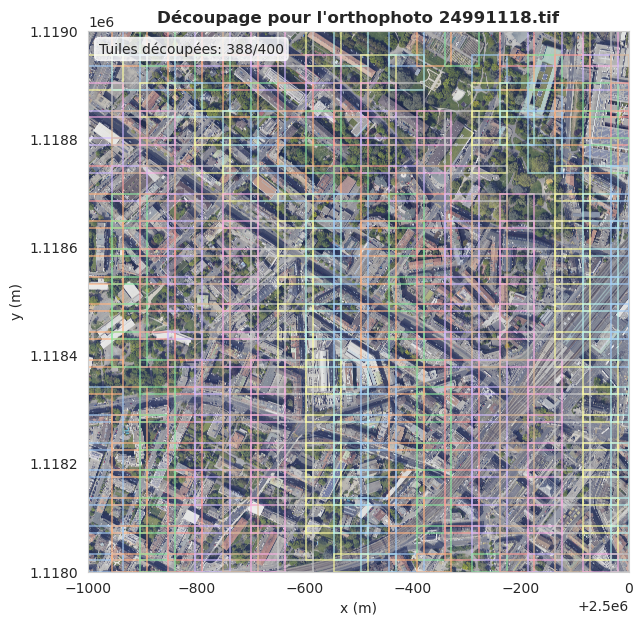

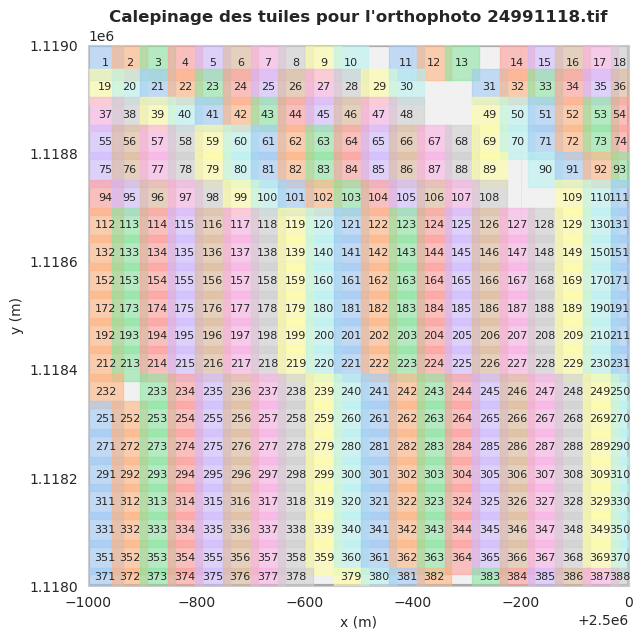

Found 436 ortho files
Selected random ortho file: 24931114.tif
Ortho file shape: (20000, 20000)
Ortho file CRS: None
Ortho file bounds: BoundingBox(left=2493000.0, bottom=1114000.0, right=2494000.0, top=1115000.0)

Searching for tiles matching: 24931114
Found 126 corresponding tiles
Successfully processed 126 tiles


KeyboardInterrupt: 

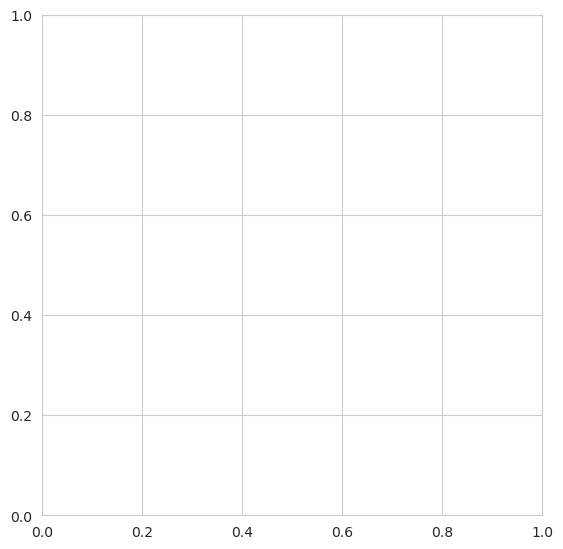

In [ ]:
import random
import os
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

def images_decoupe(
    GEOTIFF_ORTHO2019_PATH,
    TILE_1024_FOLDER_PATH,
    GRAPHICS_PATH,
    EXEMPLE_DECOUPE_ORTHOPHOTO_01_PNG,
    EXEMPLE_DECOUPE_ORTHOPHOTO_02_PNG,
    selected_tile=None,
    text_number_on_tiles=True
):
    """
    Visualizes the tiling of orthophotos and their corresponding tiles.

    Parameters:
        GEOTIFF_ORTHO2019_PATH (str): Path to the folder containing GeoTIFF orthophotos.
        TILE_1024_FOLDER_PATH (str): Path to the folder containing 1024x1024 tiles.
        GRAPHICS_PATH (str): Path to save the generated graphics.
        EXEMPLE_DECOUPE_ORTHOPHOTO_01_PNG (str): Filename for the first example image.
        EXEMPLE_DECOUPE_ORTHOPHOTO_02_PNG (str): Filename for the second example image.
        selected_tile (str, optional): Specific orthophoto file to use. If None, a random file is selected.
        text_number_on_tiles (bool): Whether to display tile numbers on the visualization.
    """
    sns.set_style("whitegrid")
    random.seed(21)

    if selected_tile:
        print(f"Using selected tile: {selected_tile}")
        random_ortho_file = selected_tile
    else:
        # List all GeoTIFF files in the orthophoto folder, excluding those ending with 'with_crs.tif'
        ortho_files = [
            f for f in os.listdir(GEOTIFF_ORTHO2019_PATH)
            if f.endswith('.tif') and not f.endswith('with_crs.tif')
        ]
        print(f"Found {len(ortho_files)} ortho files")
        random_ortho_file = random.choice(ortho_files)
        print(f"Selected random ortho file: {random_ortho_file}")

    ortho_path = os.path.join(GEOTIFF_ORTHO2019_PATH, random_ortho_file)
    try:
        with rasterio.open(ortho_path) as src:
            print(f"Ortho file shape: {src.shape}")
            print(f"Ortho file CRS: {src.crs}")
            print(f"Ortho file bounds: {src.bounds}")

            ortho_basename = os.path.splitext(random_ortho_file)[0]
            print(f"\nSearching for tiles matching: {ortho_basename}")

            tile_bounds_list = []
            tile_files = []

            if os.path.exists(TILE_1024_FOLDER_PATH):
                # Find all tiles corresponding to the selected orthophoto
                matching_tiles = [
                    f for f in os.listdir(TILE_1024_FOLDER_PATH)
                    if f.startswith(ortho_basename) and f.endswith('.tif')
                ]
                print(f"Found {len(matching_tiles)} corresponding tiles")

                # Read bounds for each tile
                for tile_file in matching_tiles:
                    tile_path = os.path.join(TILE_1024_FOLDER_PATH, tile_file)
                    try:
                        with rasterio.open(tile_path) as tile_src:
                            tile_bounds_list.append(tile_src.bounds)
                            tile_files.append(tile_file)
                    except Exception as e:
                        print(f"Error reading {tile_file}: {e}")

                print(f"Successfully processed {len(tile_bounds_list)} tiles")

                # Sort tiles by position (top-left to bottom-right)
                tile_data = []
                for bounds, filename in zip(tile_bounds_list, tile_files):
                    center_x = (bounds[0] + bounds[2]) / 2
                    center_y = (bounds[1] + bounds[3]) / 2
                    tile_data.append((bounds, filename, center_x, center_y))

                tile_data.sort(key=lambda x: (-x[3], x[2]))
                tile_bounds_list = [item[0] for item in tile_data]
                tile_files = [item[1] for item in tile_data]

                # Plot the orthophoto with tile overlays
                fig, ax = plt.subplots(figsize=(6.5, 6.5))
                show(src, ax=ax, title=f"Découpage pour l'orthophoto {random_ortho_file}")

                colors = sns.color_palette("pastel", len(tile_bounds_list))

                for i, (bounds, tile_file) in enumerate(zip(tile_bounds_list, tile_files)):
                    left, bottom, right, top = bounds
                    width = right - left
                    height = top - bottom

                    rect = patches.Rectangle(
                        (left, bottom), width, height,
                        linewidth=1.2,
                        edgecolor=colors[i],
                        facecolor='none',
                        alpha=0.7
                    )
                    ax.add_patch(rect)

                    if text_number_on_tiles:
                        center_x = left + width / 2
                        center_y = bottom + height / 2
                        ax.text(
                            center_x, center_y, str(i + 1),
                            ha='center', va='center',
                            fontsize=7, color="white",
                            fontweight='semibold'
                        )

                ax.set_xlabel('x (m)')
                ax.set_ylabel('y (m)')

                legend_text = f"Tuiles découpées: {len(tile_bounds_list)}/400"
                ax.text(
                    0.02, 0.98, legend_text, transform=ax.transAxes,
                    verticalalignment='top', ha="left",
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
                )

                ax.grid(False)
                plt.tight_layout()
                plt.savefig(
                    os.path.join(GRAPHICS_PATH, EXEMPLE_DECOUPE_ORTHOPHOTO_01_PNG),
                    dpi=300, bbox_inches='tight'
                )
                plt.show()

                # Plot the tile grid only
                fig2, ax2 = plt.subplots(figsize=(6.5, 6.5))

                main_bounds = src.bounds
                main_rect = patches.Rectangle(
                    (main_bounds[0], main_bounds[1]),
                    main_bounds[2] - main_bounds[0],
                    main_bounds[3] - main_bounds[1],
                    linewidth=3, edgecolor='black', facecolor='lightgray', alpha=0.3
                )
                ax2.add_patch(main_rect)

                for i, (bounds, tile_file) in enumerate(zip(tile_bounds_list, tile_files)):
                    left, bottom, right, top = bounds
                    width = right - left
                    height = top - bottom

                    rect = patches.Rectangle(
                        (left, bottom), width, height,
                        linewidth=1,
                        edgecolor=colors[i],
                        facecolor=colors[i],
                        alpha=0.6
                    )
                    ax2.add_patch(rect)

                    center_x = left + width / 2
                    center_y = bottom + height / 2
                    ax2.text(
                        center_x, center_y, str(i + 1),
                        ha='center', va='center', fontsize=8
                    )

                ax2.set_xlim(main_bounds[0], main_bounds[2])
                ax2.set_ylim(main_bounds[1], main_bounds[3])
                ax2.set_xlabel('x (m)')
                ax2.set_ylabel('y (m)')
                ax2.set_title(
                    f"Calepinage des tuiles pour l'orthophoto {random_ortho_file}",
                    fontsize=12, fontweight='bold'
                )
                ax2.grid(True, alpha=0.3)
                ax2.set_aspect('equal')

                plt.tight_layout()
                plt.savefig(
                    os.path.join(GRAPHICS_PATH, EXEMPLE_DECOUPE_ORTHOPHOTO_02_PNG),
                    dpi=300, bbox_inches='tight'
                )
                plt.show()

            else:
                print(f"Tile folder does not exist: {TILE_1024_FOLDER_PATH}")
    except Exception as e:
        print(f"Error processing ortho file {ortho_path}: {e}")

images_decoupe(
    GEOTIFF_ORTHO2019_PATH,
    TILE_1024_FOLDER_PATH,
    GRAPHICS_PATH,
    EXEMPLE_DECOUPE_ORTHOPHOTO_01_PNG,
    EXEMPLE_DECOUPE_ORTHOPHOTO_02_PNG,
    selected_tile="24991118.tif",
    text_number_on_tiles=False
)

images_decoupe(
    GEOTIFF_ORTHO2019_PATH,
    TILE_1024_FOLDER_PATH,
    GRAPHICS_PATH,
    EXEMPLE_DECOUPE_ORTHOPHOTO_04_PNG,
    EXEMPLE_DECOUPE_ORTHOPHOTO_05_PNG,
    selected_tile=None
)


Target tile: 24991118_tile_11_7_4db66f.tif
Tile shape: (1280, 1280)
Tile CRS: EPSG:2056
Tile bounds: BoundingBox(left=2499352.0, bottom=1118379.2, right=2499416.0, top=1118443.2)
Target tile coordinates: row=11, col=7
Found adjacent tile: 24991118_tile_10_8_2931b8.tif at (10,8)
Found adjacent tile: 24991118_tile_10_6_4fc85d.tif at (10,6)
Found adjacent tile: 24991118_tile_11_6_d743cd.tif at (11,6)
Found adjacent tile: 24991118_tile_12_8_83485c.tif at (12,8)
Found adjacent tile: 24991118_tile_10_7_18eac4.tif at (10,7)
Found adjacent tile: 24991118_tile_12_6_a82c81.tif at (12,6)
Found adjacent tile: 24991118_tile_12_7_7ce219.tif at (12,7)
Found adjacent tile: 24991118_tile_11_8_6b34a7.tif at (11,8)
Found 8 adjacent tiles


/tmp/ipykernel_4051171/4106201117.py:223: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, alpha=0.3)


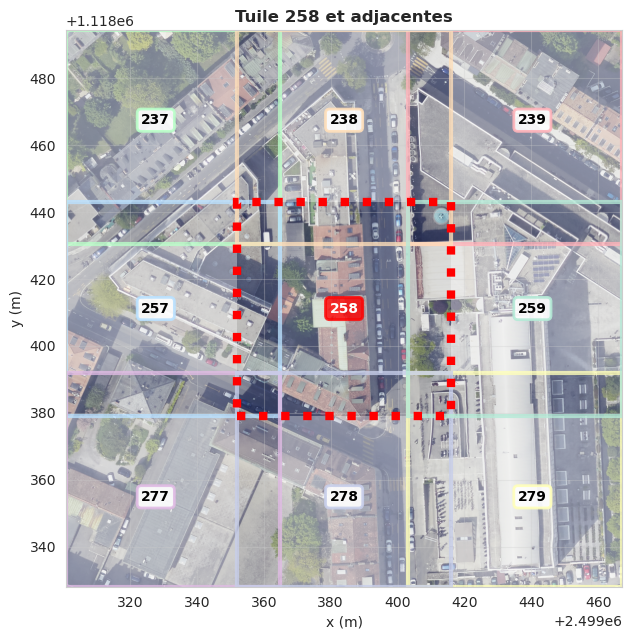


ADJACENT TILES SUMMARY
Target tile: 24991118_tile_11_7_4db66f.tif at position (11,7)
Adjacent tiles found: 8

Adjacent tiles list:
  24991118_tile_10_6_4fc85d.tif at (10,6) - NW of target
  24991118_tile_10_7_18eac4.tif at (10,7) - N of target
  24991118_tile_10_8_2931b8.tif at (10,8) - NE of target
  24991118_tile_11_6_d743cd.tif at (11,6) - W of target
  24991118_tile_11_8_6b34a7.tif at (11,8) - E of target
  24991118_tile_12_6_a82c81.tif at (12,6) - SW of target
  24991118_tile_12_7_7ce219.tif at (12,7) - S of target
  24991118_tile_12_8_83485c.tif at (12,8) - SE of target


In [ ]:
import random
import rasterio
from rasterio.plot import show
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.close()

# Configure plot style and font sizes
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12

# Specify the target tile filename
target_tile = '24991118_tile_11_7_4db66f.tif'
print(f"Target tile: {target_tile}")

# List all tile files in the specified folder
tile_files = [f for f in os.listdir(TILE_1024_FOLDER_PATH) if f.startswith('24991118_tile_') and f.endswith('.tif')]

# Check if the target tile exists; if not, try to find a similar one
if target_tile not in tile_files:
    print(f"Error: {target_tile} not found in tile_files list")
    similar_tiles = [t for t in tile_files if '24991118_tile_11_7' in t]
    print(f"Similar tiles found: {similar_tiles}")
    if similar_tiles:
        target_tile = similar_tiles[0]
        print(f"Using: {target_tile}")
    else:
        print("No similar tiles found. Exiting.")
        exit()

# Open the target tile and extract its properties
tile_path = os.path.join(TILE_1024_FOLDER_PATH, target_tile)
with rasterio.open(tile_path) as tile_src:
    print(f"Tile shape: {tile_src.shape}")
    print(f"Tile CRS: {tile_src.crs}")
    print(f"Tile bounds: {tile_src.bounds}")
    
    target_bounds = tile_src.bounds
    
    # Extract row and column indices from the filename
    parts = target_tile.split('_')
    target_row = int(parts[2])
    target_col = int(parts[3])
    print(f"Target tile coordinates: row={target_row}, col={target_col}")
    
    # Prepare to find all adjacent tiles (8 neighbors)
    adjacent_tiles = []
    adjacent_positions = [
        (target_row-1, target_col-1),  # Northwest
        (target_row-1, target_col),    # North
        (target_row-1, target_col+1),  # Northeast
        (target_row, target_col-1),    # West
        (target_row, target_col+1),    # East
        (target_row+1, target_col-1),  # Southwest
        (target_row+1, target_col),    # South
        (target_row+1, target_col+1),  # Southeast
    ]
    
    # Search for adjacent tiles in the file list
    for filename in tile_files:
        if filename.startswith('24991118_tile_'):
            parts = filename.split('_')
            try:
                row = int(parts[2])
                col = int(parts[3])
                if (row, col) in adjacent_positions:
                    tile_path_check = os.path.join(TILE_1024_FOLDER_PATH, filename)
                    try:
                        with rasterio.open(tile_path_check) as check_src:
                            bounds = check_src.bounds
                            adjacent_tiles.append((bounds, filename, row, col))
                            print(f"Found adjacent tile: {filename} at ({row},{col})")
                    except Exception as e:
                        print(f"Could not read bounds for {filename}: {e}")
            except (ValueError, IndexError):
                continue
    
    print(f"Found {len(adjacent_tiles)} adjacent tiles")
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(6.5, 6.5))
    
    # Display the target tile
    show(tile_src, ax=ax, alpha=0.8)
    
    # Define pastel colors for tile borders
    pastel_colors = [
        '#FFB3BA',  # Light pink
        '#BAFFC9',  # Light green  
        '#BAE1FF',  # Light blue
        '#FFFFBA',  # Light yellow
        '#FFDFBA',  # Light peach
        '#E0BBE4',  # Light purple
        '#C7CEEA',  # Light lavender
        '#B5EAD7',  # Light mint
        '#FFE5CC'   # Light orange
    ]
    
    all_bounds = [target_bounds]
    
    # Overlay adjacent tiles and add borders/labels
    for i, (bounds, filename, row, col) in enumerate(adjacent_tiles):
        tile_path_adj = os.path.join(TILE_1024_FOLDER_PATH, filename)
        try:
            with rasterio.open(tile_path_adj) as adj_src:
                show(adj_src, ax=ax, alpha=0.6)
                left, bottom, right, top = bounds
                width_tile = right - left
                height_tile = top - bottom
                color = pastel_colors[i % len(pastel_colors)]
                rect = patches.Rectangle(
                    (left, bottom), width_tile, height_tile,
                    linewidth=3, 
                    edgecolor=color, 
                    facecolor='none',
                    alpha=0.8
                )
                ax.add_patch(rect)
                
                # Calculate label position
                center_x = left + width_tile / 2
                center_y = bottom + height_tile / 2
                label_offset_x = (center_x - (target_bounds.left + target_bounds.right) / 2) * 0.1
                label_offset_y = (center_y - (target_bounds.bottom + target_bounds.top) / 2) * 0.1

                # Map tile filenames to numeric labels
                tile_dict = {
                    "24991118_tile_10_6_4fc85d.tif": "237",
                    "24991118_tile_10_7_18eac4.tif": "238",
                    "24991118_tile_10_8_2931b8.tif": "239",
                    "24991118_tile_11_6_d743cd.tif": "257",
                    "24991118_tile_11_8_6b34a7.tif": "259",
                    "24991118_tile_12_6_a82c81.tif": "277",
                    "24991118_tile_12_7_7ce219.tif": "278",
                    "24991118_tile_12_8_83485c.tif": "279",
                }
                tile_label = tile_dict.get(filename, filename)
                
                ax.text(center_x + label_offset_x, center_y + label_offset_y, 
                       tile_label, 
                       ha='center', va='center', 
                       fontsize=10, color='black', fontweight='demibold',
                       bbox=dict(boxstyle='round,pad=0.3', 
                               facecolor='white', 
                               alpha=0.9,
                               edgecolor=color,
                               linewidth=2))
                
                all_bounds.append(bounds)
                
        except Exception as e:
            print(f"Could not load adjacent tile {filename}: {e}")
    
    # Highlight the target tile with a red border and label
    left, bottom, right, top = target_bounds
    width_tile = right - left
    height_tile = top - bottom
    target_rect = patches.Rectangle(
        (left, bottom), width_tile, height_tile,
        linewidth=6, 
        edgecolor='red', 
        facecolor='none',
        alpha=1.0,
        ls = ":"  # Dashed line for emphasis
    )
    ax.add_patch(target_rect)
    
    # Add label for the target tile
    center_x = left + width_tile / 2
    center_y = bottom + height_tile / 2
    ax.text(center_x, center_y, 
           "258",
           ha='center', va='center', 
           fontsize=10, color='white', fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.3', 
                   facecolor='red', 
                   alpha=0.8,
                   edgecolor='red',
                   linewidth=2))
   
    # Adjust plot limits to fit all tiles with padding
    if all_bounds:
        min_x = min(b.left if hasattr(b, 'left') else b[0] for b in all_bounds)
        max_x = max(b.right if hasattr(b, 'right') else b[2] for b in all_bounds)
        min_y = min(b.bottom if hasattr(b, 'bottom') else b[1] for b in all_bounds)
        max_y = max(b.top if hasattr(b, 'top') else b[3] for b in all_bounds)
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)
    
    # Set axis labels and plot title
    ax.set_xlabel('x (m)', fontsize=10)
    ax.set_ylabel('y (m)', fontsize=10)
    ax.set_title('Tuile 258 et adjacentes', fontsize=12, fontweight='bold')
    
    ax.tick_params(axis='both', labelsize=10)
    ax.xaxis.get_offset_text().set_fontsize(10)
    ax.yaxis.get_offset_text().set_fontsize(10)
    ax.grid(False, alpha=0.3)
    
    plt.tight_layout()

    # Save the figure to file
    plt.savefig(os.path.join(GRAPHICS_PATH, EXEMPLE_DECOUPE_ORTHOPHOTO_03_PNG), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print a summary of adjacent tiles
    print(f"\n{'='*60}")
    print("ADJACENT TILES SUMMARY")
    print(f"{'='*60}")
    print(f"Target tile: {target_tile} at position ({target_row},{target_col})")
    print(f"Adjacent tiles found: {len(adjacent_tiles)}")
    print("\nAdjacent tiles list:")
    for bounds, filename, row, col in sorted(adjacent_tiles, key=lambda x: (x[2], x[3])):
        direction = ""
        if row < target_row and col < target_col:
            direction = "NW"
        elif row < target_row and col == target_col:
            direction = "N"
        elif row < target_row and col > target_col:
            direction = "NE"
        elif row == target_row and col < target_col:
            direction = "W"
        elif row == target_row and col > target_col:
            direction = "E"
        elif row > target_row and col < target_col:
            direction = "SW"
        elif row > target_row and col == target_col:
            direction = "S"
        elif row > target_row and col > target_col:
            direction = "SE"
        
        print(f"  {filename} at ({row},{col}) - {direction} of target")
    print(f"{'='*60}")


Using 16 workers for parallel processing
Available CPU cores: 128
Starting optimized processing pipeline...

=== Step 1: Collecting orthophoto metadata ===
Scanning orthophoto files...
Found 436 orthophoto files


Reading orthophoto metadata: 100%|██████████| 436/436 [00:00<00:00, 2332.90it/s]


Overall extent: (2485000.0, 1109000.0, 2514000.0, 1136000.0)
Successfully processed 436 orthophoto files

=== Step 2: Matching tiles to orthophotos ===
Scanning tile files...
Found 38813 tile files


Reading tile metadata:   5%|▌         | 2101/38813 [00:02<00:42, 858.14it/s] 

Reading tile metadata: 100%|██████████| 38813/38813 [01:02<00:00, 622.57it/s] 


Matching tiles to orthophotos...


Matching tiles: 100%|██████████| 38813/38813 [00:00<00:00, 71592.43it/s]


Successfully matched 38813 tiles to orthophotos
Sorting tiles by spatial position...


Sorting tiles: 100%|██████████| 436/436 [00:00<00:00, 20166.48it/s]



=== Step 3: Creating visualization ===
Creating canton-wide visualization...
Processing 309 orthophotos with tiles


Processing batches: 100%|██████████| 16/16 [00:43<00:00,  2.69s/it]


Saving to: data/notebook_99/graphics/20250625-185715/ch3_preparation_donnees_orthophotos_07_exemple_decoupe_orthophoto6.png


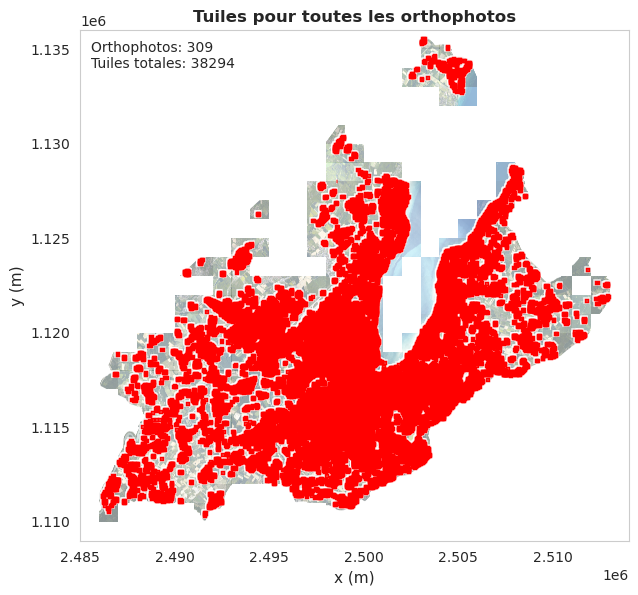

Visualization complete: 309 orthophotos, 38813 tiles


In [ ]:
import os
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import gc
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing as mp
plt.close()
# Set seaborn style for plots
sns.set_style("whitegrid")

def read_single_orthophoto_metadata(args):
    """
    Reads metadata for a single orthophoto file.
    Returns filename and metadata dictionary or None on error.
    """
    ortho_file, ortho_path = args
    ortho_filepath = os.path.join(ortho_path, ortho_file)
    try:
        with rasterio.open(ortho_filepath) as src:
            return ortho_file, {
                'bounds': src.bounds,
                'crs': src.crs,
                'shape': src.shape,
                'path': ortho_filepath,
                'tiles': []
            }
    except Exception as e:
        print(f"Error reading {ortho_file}: {e}")
        return ortho_file, None

def collect_orthophoto_metadata(ortho_path, max_workers=None):
    """
    Collects metadata for all orthophoto files in a directory using parallel processing.
    Returns a dictionary of metadata and the overall spatial extent.
    """
    print("Scanning orthophoto files...")
    ortho_files = [f for f in os.listdir(ortho_path) if f.endswith('.tif') and not f.endswith('with_crs.tif')]
    print(f"Found {len(ortho_files)} orthophoto files")
    if max_workers is None:
        max_workers = min(mp.cpu_count(), 16)
    ortho_data = {}
    all_bounds = []
    args_list = [(ortho_file, ortho_path) for ortho_file in ortho_files]
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_file = {executor.submit(read_single_orthophoto_metadata, args): args[0] 
                         for args in args_list}
        for future in tqdm(as_completed(future_to_file), total=len(ortho_files), 
                          desc="Reading orthophoto metadata"):
            ortho_file = future_to_file[future]
            try:
                filename, data = future.result()
                if data is not None:
                    ortho_data[filename] = data
                    all_bounds.append(data['bounds'])
            except Exception as e:
                print(f"Error processing {ortho_file}: {e}")
    if all_bounds:
        min_x = min(b[0] for b in all_bounds)
        min_y = min(b[1] for b in all_bounds)
        max_x = max(b[2] for b in all_bounds)
        max_y = max(b[3] for b in all_bounds)
        overall_bounds = (min_x, min_y, max_x, max_y)
        print(f"Overall extent: {overall_bounds}")
        print(f"Successfully processed {len(ortho_data)} orthophoto files")
    else:
        overall_bounds = None
    return ortho_data, overall_bounds

def read_single_tile_metadata(args):
    """
    Reads metadata for a single tile file.
    Returns filename and bounds or None on error.
    """
    tile_file, tile_path = args
    tile_filepath = os.path.join(tile_path, tile_file)
    try:
        with rasterio.open(tile_filepath) as tile_src:
            return tile_file, tile_src.bounds
    except Exception:
        return tile_file, None

def match_tiles_to_orthophotos(ortho_data, tile_path, max_workers=None):
    """
    Matches tile files to their corresponding orthophotos.
    Updates the orthophoto metadata with tile information.
    """
    if not os.path.exists(tile_path):
        print(f"Tile folder does not exist: {tile_path}")
        return ortho_data
    print("Scanning tile files...")
    tile_files = [f for f in os.listdir(tile_path) if f.endswith('.tif')]
    print(f"Found {len(tile_files)} tile files")
    if max_workers is None:
        max_workers = min(mp.cpu_count(), 16)
    ortho_basenames = {}
    for ortho_file in ortho_data.keys():
        ortho_name = os.path.splitext(ortho_file)[0]
        ortho_basenames[ortho_name] = ortho_file
    args_list = [(tile_file, tile_path) for tile_file in tile_files]
    tile_metadata = {}
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_file = {executor.submit(read_single_tile_metadata, args): args[0] 
                         for args in args_list}
        for future in tqdm(as_completed(future_to_file), total=len(tile_files), 
                          desc="Reading tile metadata"):
            tile_file = future_to_file[future]
            try:
                filename, bounds = future.result()
                if bounds is not None:
                    tile_metadata[filename] = bounds
            except Exception as e:
                print(f"Error processing {tile_file}: {e}")
                continue
    tiles_processed = 0
    print("Matching tiles to orthophotos...")
    for tile_file, tile_bounds in tqdm(tile_metadata.items(), desc="Matching tiles"):
        matched_ortho = None
        for ortho_name, ortho_file in ortho_basenames.items():
            if tile_file.startswith(ortho_name):
                matched_ortho = ortho_file
                break
        if matched_ortho:
            ortho_data[matched_ortho]['tiles'].append({
                'filename': tile_file,
                'bounds': tile_bounds
            })
            tiles_processed += 1
    print(f"Successfully matched {tiles_processed} tiles to orthophotos")
    # Sort tiles for each orthophoto by spatial position
    print("Sorting tiles by spatial position...")
    for ortho_file in tqdm(ortho_data.keys(), desc="Sorting tiles"):
        tiles = ortho_data[ortho_file]['tiles']
        if tiles:
            tile_data = []
            for tile in tiles:
                bounds = tile['bounds']
                center_x = (bounds[0] + bounds[2]) * 0.5
                center_y = (bounds[1] + bounds[3]) * 0.5
                tile_data.append((tile, center_x, center_y))
            # Sort by y descending (top first), then x ascending (left first)
            tile_data.sort(key=lambda x: (-x[2], x[1]))
            ortho_data[ortho_file]['tiles'] = [item[0] for item in tile_data]
    return ortho_data

def process_single_orthophoto(args):
    """
    Processes a single orthophoto for visualization.
    Returns image data, extent, tile patches, and tile count.
    """
    ortho_file, data, tile_color, downsample_target = args
    try:
        with rasterio.open(data['path']) as src:
            downsample_factor = max(1, max(src.shape) // downsample_target)
            downsampled_data = src.read(
                out_shape=(src.count, src.height // downsample_factor, src.width // downsample_factor),
                resampling=Resampling.nearest
            )
            extent = [data['bounds'][0], data['bounds'][2], data['bounds'][1], data['bounds'][3]]
            if downsampled_data.shape[0] >= 3:
                img_data = np.transpose(downsampled_data[:3], (1, 2, 0))
                p98 = np.percentile(img_data, 98)
                if p98 > 0:
                    img_data = np.clip(img_data / p98 * 255, 0, 255).astype(np.uint8)
            else:
                img_data = downsampled_data[0]
            tile_patches = []
            for tile in data['tiles']:
                tile_bounds = tile['bounds']
                left, bottom, right, top = tile_bounds
                width_tile = right - left
                height_tile = top - bottom
                rect_data = {
                    'xy': (left, bottom),
                    'width': width_tile,
                    'height': height_tile,
                    'color': tile_color
                }
                tile_patches.append(rect_data)
            return ortho_file, img_data, extent, tile_patches, len(data['tiles'])
    except Exception as e:
        print(f"Error processing {ortho_file}: {e}")
        return ortho_file, None, None, None, 0

def create_canton_visualization(ortho_data, overall_bounds, output_path=None, downsample_target=600):
    """
    Creates a visualization showing all orthophotos and their tile divisions.
    """
    print("Creating canton-wide visualization...")
    width = overall_bounds[2] - overall_bounds[0]
    height = overall_bounds[3] - overall_bounds[1]
    aspect_ratio = width / height
    fig_width = 6.5
    fig_height = fig_width / aspect_ratio
    if fig_height > 30:
        fig_height = 30
        fig_width = fig_height * aspect_ratio
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    orthos_with_tiles = {k: v for k, v in ortho_data.items() if v['tiles']}
    print(f"Processing {len(orthos_with_tiles)} orthophotos with tiles")
    tile_color = '#FF0000'  # Use red for tile boundaries
    max_workers = min(16, mp.cpu_count())
    batch_size = 20
    ortho_items = list(orthos_with_tiles.items())
    total_tiles = 0
    ortho_count = 0
    for batch_start in tqdm(range(0, len(ortho_items), batch_size), desc="Processing batches"):
        batch_end = min(batch_start + batch_size, len(ortho_items))
        batch_items = ortho_items[batch_start:batch_end]
        args_list = [(ortho_file, data, tile_color, downsample_target) 
                    for ortho_file, data in batch_items]
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(process_single_orthophoto, args) for args in args_list]
            for future in as_completed(futures):
                try:
                    ortho_file, img_data, extent, tile_patches, num_tiles = future.result()
                    if img_data is not None:
                        # Show orthophoto with reduced alpha for tile visibility
                        ax.imshow(img_data, extent=extent, alpha=0.6)
                        # Draw tile boundaries with white outline and red border
                        for patch_data in tile_patches:
                            rect_outline = patches.Rectangle(
                                patch_data['xy'], patch_data['width'], patch_data['height'],
                                linewidth=4.0, 
                                edgecolor='white', 
                                facecolor='none',
                                alpha=0.8,
                                zorder=1
                            )
                            ax.add_patch(rect_outline)
                            rect_main = patches.Rectangle(
                                patch_data['xy'], patch_data['width'], patch_data['height'],
                                linewidth=2.5, 
                                edgecolor=tile_color, 
                                facecolor='none',
                                alpha=1.0,
                                zorder=2
                            )
                            ax.add_patch(rect_main)
                        total_tiles += num_tiles
                        ortho_count += 1
                except Exception as e:
                    print(f"Error in batch processing: {e}")
        gc.collect()
    ax.set_xlim(overall_bounds[0], overall_bounds[2])
    ax.set_ylim(overall_bounds[1], overall_bounds[3])
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_title('Tuiles pour toutes les orthophotos', fontsize=12, fontweight='bold')
    info_text = f"Orthophotos: {ortho_count}\nTuiles totales: 38294"
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
           verticalalignment='top', horizontalalignment='left', 
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    ax.grid(False)
    ax.set_aspect('equal')
    plt.tight_layout()
    if output_path:
        print(f"Saving to: {output_path}")
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Visualization complete: {ortho_count} orthophotos, {total_tiles} tiles")
    return fig, ax

def process_all_orthophotos(ortho_path, tile_path, output_path=None, max_workers=None):
    """
    Runs the workflow to process all orthophotos and create a visualization.
    """
    print("Starting optimized processing pipeline...")
    ortho_data, overall_bounds = collect_orthophoto_metadata(ortho_path, max_workers)
    if not ortho_data:
        print("No orthophoto data found")
        return None
    ortho_data = match_tiles_to_orthophotos(ortho_data, tile_path, max_workers)
    fig, ax = create_canton_visualization(ortho_data, overall_bounds, output_path)
    return ortho_data, overall_bounds, fig, ax

def run_optimized_processing(ortho_path, tile_path, output_path):
    """
    Runs the complete processing pipeline with optimal worker count.
    """
    cpu_count = mp.cpu_count()
    optimal_workers = min(cpu_count, 16)
    print(f"Using {optimal_workers} workers for parallel processing")
    print(f"Available CPU cores: {cpu_count}")
    return process_all_orthophotos(ortho_path, tile_path, output_path, optimal_workers)

# Example usage with existing variables
result = run_optimized_processing(
    GEOTIFF_ORTHO2019_PATH, 
    TILE_1024_FOLDER_PATH, 
    os.path.join(GRAPHICS_PATH, EXEMPLE_DECOUPE_ORTHOPHOTO_06_PNG)
)


## ch3 post_traitement dataset

PNG saved: data/notebook_99/graphics/20250625-185715/ch3_postprocessing_dataset_03_overview.png (300.9 KB, 3703x1554)


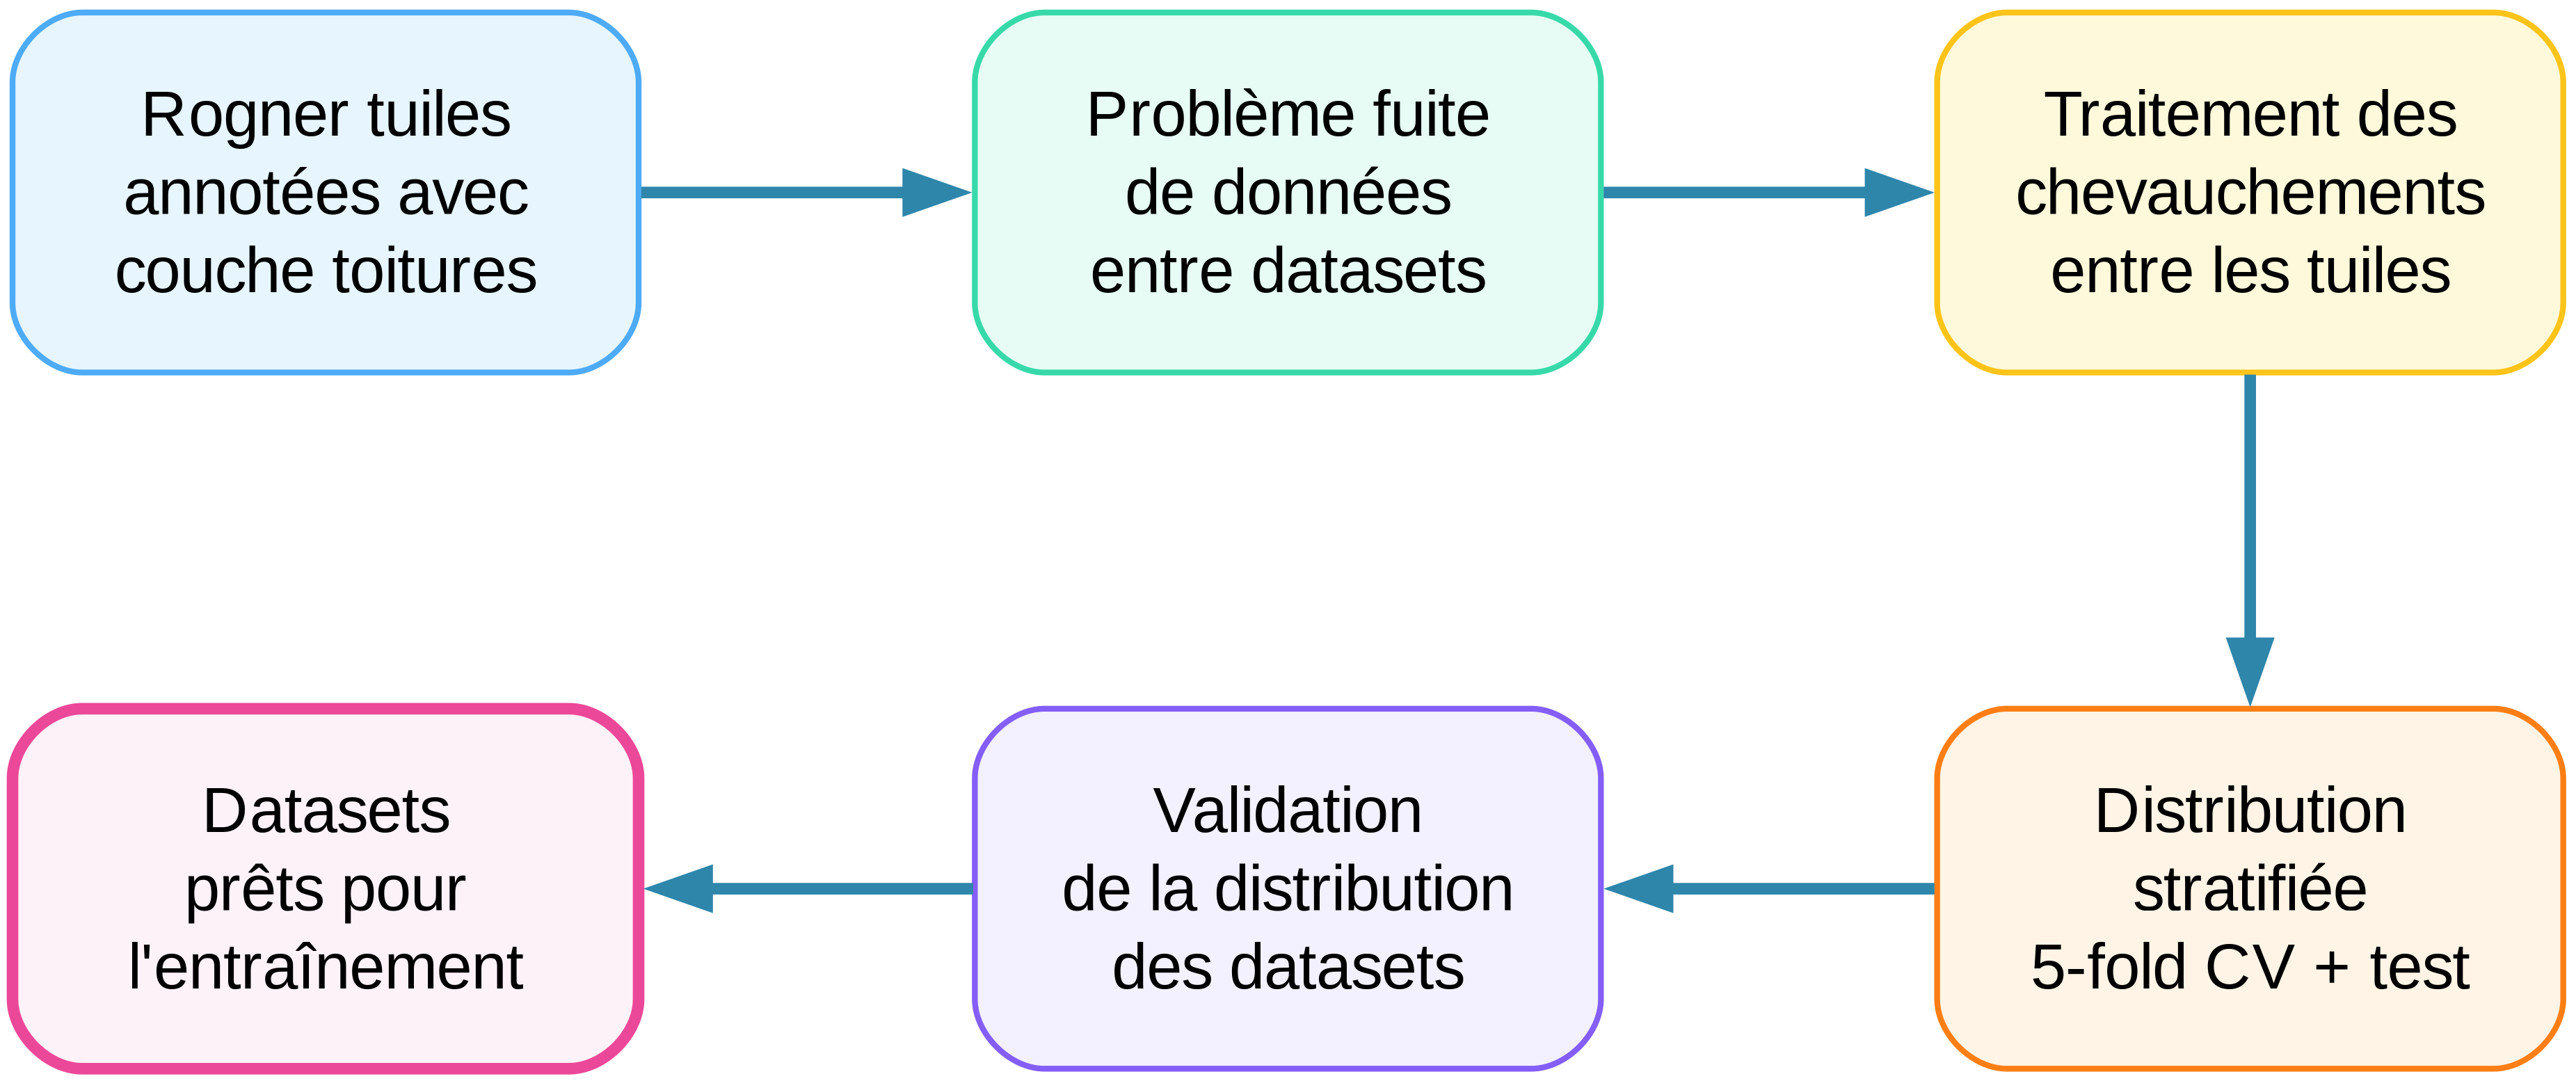

In [ ]:
from kroki import diagram_image

graphviz_code = '''
    digraph DatasetDistributionProcess {
        rankdir=TB;
        bgcolor=white;
        fontname="Arial";
        fontsize=11;
        pad="0.03";
        nodesep="0.8";
        ranksep="0.8";
        ratio=compress;
        dpi=600;
        size="10,10"
        ordering=out;
        
        // Base node style
        node [shape=box, style="rounded,filled", fontname="Arial", fontsize=11,
              margin="0.15", width="1.5", height="0.4", penwidth=1];
        
        // Edge style
        edge [color="#2E86AB", penwidth=2, arrowsize=0.8, fontsize=11];
        
        // Subgraph for dataset distribution workflow
        subgraph cluster_0 {
            label="Processus de répartition en datasets 5 k-folds et test";
            style=rounded;
            color="#2A4D7E";
            fontsize=11;
            
            // Step 1 - Light Blue
            step1 [label="Rogner tuiles\\nannotées avec\\ncouche toitures", 
                   fillcolor="#e7f5ff", color="#4dabf7"];
            
            // Step 2 - Light Green  
            step2 [label="Problème fuite\\nde données\\nentre datasets", 
                   fillcolor="#e6fcf5", color="#38d9a9"];
            
            // Step 3 - Light Yellow
            step3 [label="Traitement des\\nchevauchements\\nentre les tuiles", 
                   fillcolor="#fff9db", color="#fcc419"];
            
            // Step 4 - Light Orange
            step4 [label="Distribution\\nstratifiée\\n5-fold CV + test", 
                   fillcolor="#fff4e6", color="#fd7e14"];
            
            // Step 5 - Light Purple
            step5 [label="Validation\\nde la distribution\\ndes datasets", 
                   fillcolor="#f3f0ff", color="#845ef7"];
            
            // Step 6 - Light Pink
            step6 [label="Datasets\\nprêts pour\\nl'entraînement", 
                   fillcolor="#fdf2f8", color="#ec4899",
                   penwidth="2", style="rounded,filled,bold"];
        }
        
        // Define ranking for clean vertical layout
        {rank=source; step1, step2, step3}
        {rank=same; step4, step5, step6}
        
        // Sequential flow
        step1 -> step2 -> step3;
        step4 -> step3 [dir=back];
        step6 -> step5 -> step4 [dir=back];

    }
    '''

png_data = diagram_image(graphviz_code, diagram_type='graphviz', output_format='png')

# Save to file (adjust path as needed)
save_high_quality_kroki(png_data, os.path.join(GRAPHICS_PATH, POST_TREATMENT_DATASET_01_OVERVIEW_PNG))

display(png_data)

In [ ]:
import geopandas as gpd

df= gpd.read_parquet(TILE_1024_FOLDER_PATH + "/combined_metadata.parquet")

In [ ]:
df

,geotiff_path,tile_path,tile_id,tile_row,tile_col,tile_bounds,buffered_bounds,tile_size,buffer_size,tile_pixel_size,objectid,egid,altitude_min,altitude_max,date_leve,SHAPE__Length,SHAPE__Area,globalid,geometry
0,data/SITG/ortho2019/24871114.tif,data/notebook_04/geotiff/tile_1024_split/24871...,13_13_e94127,13,13,"(2487665.6, 1114283.2, 2487716.8, 1114334.4)","(2487659.2, 1114276.8, 2487723.2, 1114340.8)",1024,128,"[1024, 1024]",25788,295083444.0,403.03,403.03,2005-08-01 02:00:00,16.331961,16.433512,BC2A0AB2-CF99-4773-9E37-27F5B009F149,None
1,data/SITG/ortho2019/24871114.tif,data/notebook_04/geotiff/tile_1024_split/24871...,15_11_31a896,15,11,"(2487563.2, 1114180.8, 2487614.4, 1114232.0)","(2487556.8, 1114174.4, 2487620.8, 1114238.4)",1024,128,"[1024, 1024]",25519,1000679.0,404.74,406.33,2005-08-01 02:00:00,32.321716,60.530621,104A05FD-82FE-427F-B9E8-D10F1705FA03,None
2,data/SITG/ortho2019/24871114.tif,data/notebook_04/geotiff/tile_1024_split/24871...,15_12_3d94dd,15,12,"(2487614.4, 1114180.8, 2487665.6, 1114232.0)","(2487608.0, 1114174.4, 2487672.0, 1114238.4)",1024,128,"[1024, 1024]",25520,1000679.0,402.28,406.33,2005-08-01 02:00:00,38.237267,90.706342,53F40786-A2BA-4EBF-A807-925E5D3B298A,None
3,data/SITG/ortho2019/24871114.tif,data/notebook_04/geotiff/tile_1024_split/24871...,15_12_3d94dd,15,12,"(2487614.4, 1114180.8, 2487665.6, 1114232.0)","(2487608.0, 1114174.4, 2487672.0, 1114238.4)",1024,128,"[1024, 1024]",25519,1000679.0,404.74,406.33,2005-08-01 02:00:00,32.321716,60.530621,104A05FD-82FE-427F-B9E8-D10F1705FA03,None
4,data/SITG/ortho2019/24871114.tif,data/notebook_04/geotiff/tile_1024_split/24871...,15_13_1ce369,15,13,"(2487665.6, 1114180.8, 2487716.8, 1114232.0)","(2487659.2, 1114174.4, 2487723.2, 1114238.4)",1024,128,"[1024, 1024]",257925,295084620.0,403.04,403.04,2011-04-01 02:00:00,18.437257,20.428779,E67E61CA-7311-43BD-8906-5F083D99C785,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675409,data/SITG/ortho2019/25091121.tif,data/notebook_04/geotiff/tile_1024_split/25091...,19_12_6f74ea,19,12,"(2509614.4, 1121000.0, 2509665.6, 1121027.2)","(2509608.0, 1121000.0, 2509672.0, 1121033.6)",1024,128,"[1024, 544]",129957,295010409.0,478.05,480.00,2005-08-01 02:00:00,40.362044,33.271916,D48D0EEE-459F-4A44-BB72-0DB4A8E931A8,None
675410,data/SITG/ortho2019/25091121.tif,data/notebook_04/geotiff/tile_1024_split/25091...,19_12_6f74ea,19,12,"(2509614.4, 1121000.0, 2509665.6, 1121027.2)","(2509608.0, 1121000.0, 2509672.0, 1121033.6)",1024,128,"[1024, 544]",129960,295010409.0,479.01,479.90,2005-08-01 02:00:00,13.580154,9.595070,7E506A52-9A88-4AC5-B999-59EAB9AB3D08,None
675411,data/SITG/ortho2019/25091121.tif,data/notebook_04/geotiff/tile_1024_split/25091...,19_12_6f74ea,19,12,"(2509614.4, 1121000.0, 2509665.6, 1121027.2)","(2509608.0, 1121000.0, 2509672.0, 1121033.6)",1024,128,"[1024, 544]",129958,295010409.0,478.64,482.19,2005-08-01 02:00:00,60.956856,151.113287,84BA8563-280E-412A-A23D-589318121803,None
675412,data/SITG/ortho2019/25091121.tif,data/notebook_04/geotiff/tile_1024_split/25091...,19_12_6f74ea,19,12,"(2509614.4, 1121000.0, 2509665.6, 1121027.2)","(2509608.0, 1121000.0, 2509672.0, 1121033.6)",1024,128,"[1024, 544]",129961,295010410.0,478.64,482.19,2005-08-01 02:00:00,58.687432,165.929841,16D46C1F-9042-42A4-BA28-67E341302EC9,None


In [ ]:
len(df["egid"].unique())
# len(df["tile_path"].unique())


78421

In [ ]:
gdf_toiture_7_classification = gpd.read_parquet("data/notebook_02/parquet/02_gdf_toiture_7_classification.parquet")
len(gdf_toiture_7_classification["egid"].unique())

# display the values that are in df["egid"].unique() but not in gdf_toiture_7_classification["egid"].unique()
missing_egids = set(df["egid"].unique()) - set(gdf_toiture_7_classification["egid"].unique())
print(f"Missing EGIDs: {missing_egids}")

# remove from df egid that are not in gdf_toiture_7_classification
df = df[df["egid"].isin(gdf_toiture_7_classification["egid"].unique())]

Missing EGIDs: {2051.0, 2052.0, 2053.0, 2054.0, 2057.0, 2058.0, 2061.0, 2062.0, 2063.0, 6167.0, 28.0, 30.0, 31.0, 35.0, 36.0, 37.0, 100392.0, 100395.0, 100396.0, 100397.0, 100398.0, 100399.0, 49.0, 54.0, 65.0, 93.0, 2151.0, 110.0, 112.0, 113.0, 115.0, 2164.0, 117.0, 2165.0, 2173.0, 133.0, 135.0, 2184.0, 100492.0, 142.0, 100494.0, 100495.0, 100496.0, 100497.0, 100499.0, 148.0, 295074.0, 170.0, 180.0, 181.0, 182.0, 183.0, 184.0, 185.0, 186.0, 188.0, 189.0, 190.0, 191.0, 192.0, 193.0, 194.0, 195.0, 196.0, 197.0, 198.0, 199.0, 2250.0, 2251.0, 2252.0, 2253.0, 2254.0, 2255.0, 2257.0, 2258.0, 2260.0, 2264.0, 2265.0, 220.0, 2270.0, 226.0, 227.0, 228.0, 2275.0, 230.0, 232.0, 2280.0, 2281.0, 235.0, 2282.0, 2284.0, 2285.0, 100592.0, 100593.0, 2290.0, 100595.0, 100596.0, 245.0, 100597.0, 248.0, 268.0, 272.0, 273.0, 274.0, 275.0, 276.0, 277.0, 279.0, 280.0, 281.0, 282.0, 283.0, 284.0, 285.0, 286.0, 287.0, 288.0, 290.0, 291.0, 292.0, 293.0, 294.0, 295.0, 296.0, 297.0, 298.0, 308.0, 310.0, 311.0, 313

## ch36 modèles

🚀 Segmentation Models Analysis Tool
🔍 Analyzing Model Architectures (Backbone: tu-resnet34)
Testing U-Net... ✅
Testing U-Net++... ✅
Testing MAnet... ✅
Testing LinkNet... ✅
Testing FPN... 

✅
Testing PAN... ✅
Testing PSPNet... ✅
Testing SegFormer... ✅
Testing DeepLabV3+... ✅
Testing UPerNet... ✅
Testing DPT... ✅

📊 Architecture Comparison Results
------------------------------------------------------------------------------------------
+----------------+-----------+-----------+---------+---------+--------+--------+
| Architecture   | Decoder   | Encoder   | Head    | Total   | Dec%   | Enc%   |
+================+===========+===========+=========+=========+========+========+
| DPT            | 29.58M    | 21.80M    | 590.59K | 51.97M  | 56.9%  | 41.9%  |
+----------------+-----------+-----------+---------+---------+--------+--------+
| MAnet          | 10.50M    | 21.28M    | 145     | 31.78M  | 33.0%  | 67.0%  |
+----------------+-----------+-----------+---------+---------+--------+--------+
| UPerNet        | 8.31M     | 21.28M    | 257     | 29.60M  | 28.1%  | 71.9%  |
+----------------+-----------+-----------+---------+---------+--------+--------+
| U-Net++        | 4.

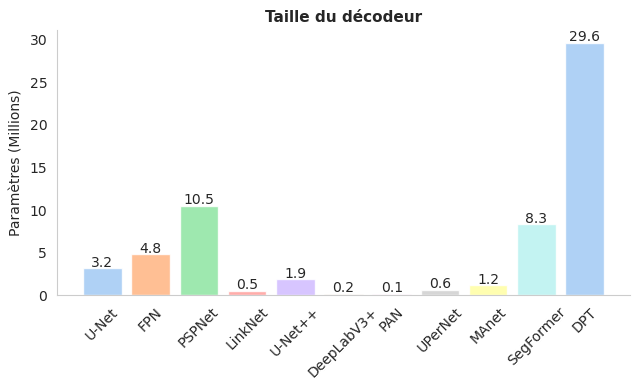

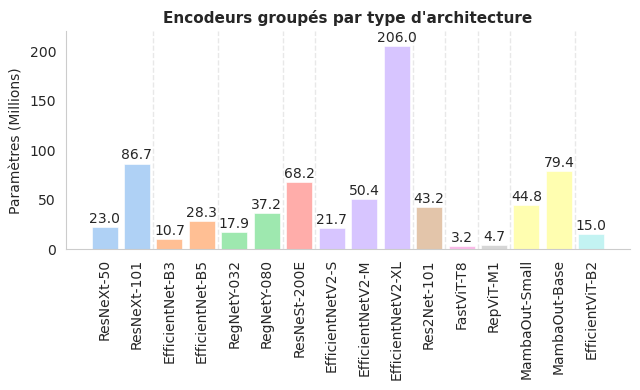

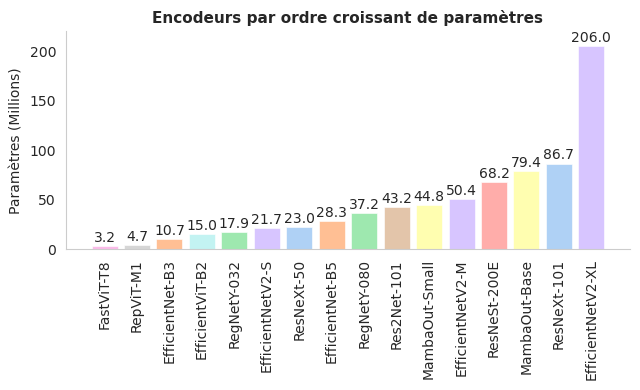


✅ Analysis complete!


In [ ]:
import segmentation_models_pytorch as smp
import torch
import logging
import warnings
from typing import Dict, List, Any, Optional
from dataclasses import dataclass
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings and set minimal logging
warnings.filterwarnings('ignore')
logging.getLogger('timm').setLevel(logging.ERROR)
logging.getLogger('__main__').setLevel(logging.ERROR)

@dataclass
class ModelStats:
    """Stores statistics for a segmentation model."""
    architecture: str
    backbone: str
    encoder_params: int
    decoder_params: int
    head_params: int
    total_params: int
    decoder_ratio: float
    encoder_ratio: float
    status: str = "success"
    error: Optional[str] = None

class ModelAnalyzer:
    """Analyzes segmentation model architectures and backbones."""
    
    def __init__(self):
        # Mapping of architecture names to model classes
        self.model_creators = {
            "U-Net": smp.Unet,
            "U-Net++": smp.UnetPlusPlus,
            "MAnet": smp.MAnet,
            "LinkNet": smp.Linknet,
            "FPN": smp.FPN,
            "PAN": smp.PAN,
            "PSPNet": smp.PSPNet,
            "SegFormer": smp.Segformer,
            "DeepLabV3+": smp.DeepLabV3Plus,
            "UPerNet": smp.UPerNet,
            "DPT": smp.DPT,
        }
        
        # List of common backbones to test
        self.common_backbones = [
            "timm-efficientnet-b3",
            "tu-efficientvit_b2.r224_in1k",
            "tu-fastvit_t8.apple_in1k",
            "tu-repvit_m1.dist_in1k",
            "tu-regnety_032.ra_in1k",
            "tu-mambaout_small",
            "tu-efficientnetv2_rw_s.ra2_in1k",
            "tu-regnety_080.ra3_in1k",
            "timm-res2net101_26w_4s",
            "resnext50_32x4d",
            "tu-mambaout_base",
            "tu-efficientnetv2_rw_m.agc_in1k",
            "timm-resnest200e",
            "resnext101_32x8d",
            "timm-efficientnet-b5",
            "tu-tf_efficientnetv2_xl.in21k_ft_in1k"
        ]
    
    @staticmethod
    def count_parameters(model_part) -> int:
        """Returns the number of parameters in a model component."""
        return sum(p.numel() for p in model_part.parameters())
    
    @staticmethod
    def format_params(count: int) -> str:
        """Formats parameter count for readability."""
        if count >= 1e9:
            return f"{count/1e9:.2f}B"
        elif count >= 1e6:
            return f"{count/1e6:.2f}M"
        elif count >= 1e3:
            return f"{count/1e3:.2f}K"
        else:
            return str(count)
    
    def analyze_model(self, architecture: str, model_class, backbone: str = "resnet34") -> ModelStats:
        """Analyzes a single model architecture with the specified backbone."""
        try:
            model_params = {
                "encoder_name": backbone,
                "encoder_weights": "imagenet",
                "in_channels": 3,
                "classes": 1,
                "activation": None,
            }
            model = model_class(**model_params)
            total_params = self.count_parameters(model)
            encoder_params = self.count_parameters(model.encoder) if hasattr(model, 'encoder') else 0
            decoder_params = self.count_parameters(model.decoder) if hasattr(model, 'decoder') else 0
            head_params = 0
            if hasattr(model, 'segmentation_head'):
                head_params = self.count_parameters(model.segmentation_head)
            elif hasattr(model, 'classification_head'):
                head_params = self.count_parameters(model.classification_head)
            decoder_ratio = (decoder_params / total_params * 100) if total_params > 0 else 0
            encoder_ratio = (encoder_params / total_params * 100) if total_params > 0 else 0
            return ModelStats(
                architecture=architecture,
                backbone=backbone,
                encoder_params=encoder_params,
                decoder_params=decoder_params,
                head_params=head_params,
                total_params=total_params,
                decoder_ratio=decoder_ratio,
                encoder_ratio=encoder_ratio
            )
        except Exception as e:
            return ModelStats(
                architecture=architecture,
                backbone=backbone,
                encoder_params=0,
                decoder_params=0,
                head_params=0,
                total_params=0,
                decoder_ratio=0,
                encoder_ratio=0,
                status="error",
                error=str(e)[:100]
            )
    
    def analyze_architectures(self, backbone: str = "resnet34") -> List[ModelStats]:
        """Analyzes all architectures using the specified backbone."""
        print(f"Analyzing Model Architectures (Backbone: {backbone})")
        print("=" * 90)
        results = []
        for arch_name, model_class in self.model_creators.items():
            print(f"Testing {arch_name}...", end=" ")
            stats = self.analyze_model(arch_name, model_class, backbone)
            results.append(stats)
            if stats.status == "success":
                print("OK")
            else:
                print(f"FAILED ({stats.error[:30]}...)")
        self._display_architecture_results(results, backbone)
        return results
    
    def analyze_backbones(self, architecture: str = "U-Net") -> List[ModelStats]:
        """Analyzes different backbones for a single architecture."""
        print(f"\nAnalyzing Backbones (Architecture: {architecture})")
        print("=" * 90)
        model_class = self.model_creators.get(architecture)
        if not model_class:
            print(f"FAILED: Architecture '{architecture}' not found!")
            return []
        results = []
        for backbone in self.common_backbones:
            print(f"Testing {backbone}...", end=" ")
            stats = self.analyze_model(architecture, model_class, backbone)
            results.append(stats)
            if stats.status == "success":
                print("OK")
            else:
                print(f"FAILED ({stats.error[:30]}...)")
        self._display_backbone_results(results)
        return results
    
    def _display_architecture_results(self, results: List[ModelStats], backbone: str):
        """Displays a table comparing architectures."""
        print("\nArchitecture Comparison Results")
        print("-" * 90)
        successful_results = [r for r in results if r.status == "success"]
        failed_results = [r for r in results if r.status == "error"]
        if successful_results:
            successful_results.sort(key=lambda x: x.decoder_params, reverse=True)
            headers = ["Architecture", "Decoder", "Encoder", "Head", "Total", "Dec%", "Enc%"]
            table_data = []
            for stats in successful_results:
                table_data.append([
                    stats.architecture,
                    self.format_params(stats.decoder_params),
                    self.format_params(stats.encoder_params),
                    self.format_params(stats.head_params),
                    self.format_params(stats.total_params),
                    f"{stats.decoder_ratio:.1f}%",
                    f"{stats.encoder_ratio:.1f}%"
                ])
            print(tabulate(table_data, headers=headers, tablefmt="grid"))
            self._print_architecture_summary(successful_results, backbone)
        if failed_results:
            print(f"\nFailed Models ({len(failed_results)}):")
            for result in failed_results:
                print(f"  • {result.architecture}: {result.error}")
    
    def _display_backbone_results(self, results: List[ModelStats]):
        """Displays a table comparing backbones."""
        print("\nBackbone Comparison Results")
        print("-" * 70)
        successful_results = [r for r in results if r.status == "success"]
        failed_results = [r for r in results if r.status == "error"]
        if successful_results:
            successful_results.sort(key=lambda x: x.total_params)
            headers = ["Backbone", "Encoder", "Decoder", "Total", "Enc%"]
            table_data = []
            for stats in successful_results:
                table_data.append([
                    stats.backbone,
                    self.format_params(stats.encoder_params),
                    self.format_params(stats.decoder_params),
                    self.format_params(stats.total_params),
                    f"{stats.encoder_ratio:.1f}%"
                ])
            print(tabulate(table_data, headers=headers, tablefmt="grid"))
            self._print_backbone_summary(successful_results)
        if failed_results:
            print(f"\nFailed Backbones ({len(failed_results)}):")
            for result in failed_results:
                print(f"  • {result.backbone}: {result.error}")
    
    def _print_architecture_summary(self, results: List[ModelStats], backbone: str):
        """Prints summary statistics for architecture analysis."""
        print(f"\nSummary Statistics (Backbone: {backbone})")
        print("-" * 50)
        if not results:
            print("No successful results to analyze.")
            return
        decoder_sizes = [r.decoder_params for r in results]
        min_decoder = min(results, key=lambda x: x.decoder_params)
        max_decoder = max(results, key=lambda x: x.decoder_params)
        print(f"Models analyzed: {len(results)}")
        print(f"Encoder size: {self.format_params(results[0].encoder_params)} (consistent)")
        print(f"Decoder range: {self.format_params(min(decoder_sizes))} - {self.format_params(max(decoder_sizes))}")
        print(f"Smallest decoder: {min_decoder.architecture} ({self.format_params(min_decoder.decoder_params)})")
        print(f"Largest decoder: {max_decoder.architecture} ({self.format_params(max_decoder.decoder_params)})")
        efficient_models = [r for r in results if r.decoder_ratio < 10]
        heavy_models = [r for r in results if r.decoder_ratio > 25]
        print("\nInsights:")
        print(f"  • Efficient models (<10% decoder): {[r.architecture for r in efficient_models]}")
        print(f"  • Heavy decoders (>25% decoder): {[r.architecture for r in heavy_models]}")
        print("\nRecommendations:")
        print(f"  • For speed: {min_decoder.architecture} (smallest decoder)")
        print(f"  • For accuracy: {max_decoder.architecture} (largest decoder)")
        balanced = min(results, key=lambda x: abs(x.decoder_ratio - 15))
        print(f"  • For balance: {balanced.architecture} ({balanced.decoder_ratio:.1f}% decoder)")
    
    def _print_backbone_summary(self, results: List[ModelStats]):
        """Prints summary statistics for backbone analysis."""
        print("\nSummary Statistics")
        print("-" * 30)
        if not results:
            print("No successful results to analyze.")
            return
        min_total = min(results, key=lambda x: x.total_params)
        max_total = max(results, key=lambda x: x.total_params)
        print(f"Backbones tested: {len(results)}")
        print(f"Size range: {self.format_params(min_total.total_params)} - {self.format_params(max_total.total_params)}")
        print(f"Smallest: {min_total.backbone} ({self.format_params(min_total.total_params)})")
        print(f"Largest: {max_total.backbone} ({self.format_params(max_total.total_params)})")
        decoder_sizes = [r.decoder_params for r in results]
        if len(set(decoder_sizes)) == 1:
            print(f"Decoder size: {self.format_params(decoder_sizes[0])} (consistent across backbones)")
        else:
            print(f"Decoder varies: {self.format_params(min(decoder_sizes))} - {self.format_params(max(decoder_sizes))}")
    
    def create_comparison_plot(self, arch_results: List[ModelStats], backbone_results: List[ModelStats]):
        """Creates plots for architecture and backbone comparisons."""
       
        def compare_architectures(arch_results):
            """Plots decoder sizes for different architectures."""
            sns.set_style("whitegrid")
            pastel_palette = sns.color_palette("pastel")
            plt.rcParams['font.size'] = 10
            plt.rcParams['axes.labelsize'] = 10
            plt.rcParams['axes.titlesize'] = 11
            fig, ax1 = plt.subplots(figsize=(6.5, 4))
            successful_arch = [r for r in arch_results if r.status == "success"]
            if successful_arch:
                archs = [r.architecture for r in successful_arch]
                archs_ordered = ['U-Net', 'FPN', 'PSPNet', 'LinkNet', 'U-Net++', 'DeepLabV3+', 'PAN', 'UPerNet', 'MAnet', 'SegFormer', 'DPT']
                archs = sorted(archs, key=lambda x: archs_ordered.index(x) if x in archs_ordered else len(archs_ordered))
                decoder_sizes = [r.decoder_params / 1e6 for r in successful_arch]
                ax1.bar(archs, decoder_sizes, color=pastel_palette[:len(archs)], alpha=0.85)
                ax1.set_title('Decoder Size', fontsize=11, fontweight='bold')
                ax1.set_ylabel('Parameters (Millions)')
                ax1.tick_params(axis='x', rotation=45)
                for i, v in enumerate(decoder_sizes):
                    ax1.text(i, v + 1.5, f"{v:.1f}", ha='center', va='top', fontsize=10)
            ax1.grid(False)
            sns.despine()
            plt.tight_layout()
            plt.savefig(os.path.join(GRAPHICS_PATH, ARCHITECTURE_SIZE_DECODER_PNG), dpi=300, bbox_inches='tight')
            plt.show()
        
        def compare_backbones_family(backbone_results):
            """Plots encoder sizes grouped by backbone family."""
            sns.set_style("whitegrid")
            plt.rcParams['font.size'] = 10
            plt.rcParams['axes.labelsize'] = 10
            plt.rcParams['axes.titlesize'] = 11
            backbone_families = {
                "ResNext": ['resnext50', 'resnext101'],
                "EfficientNet" : ["efficientnet-b3", "efficientnet-b5"],
                "RegNetY" : ["regnety_032", "regnety_080"],
                "ResNeSt": ["resnest200e"],
                "EfficientNetV2": ["efficientnetv2_rw_s", "efficientnetv2_rw_m", "tf_efficientnetv2_xl"],
                "Res2Net": ["res2net101_26w_4s"],
                "FastViT": ["fastvit_t8"],
                "RepViT": ["repvit_m1"],
                "MambaOut": ["mambaout_small", "mambaout_base"],
                "EfficientViT": ["efficientvit_b2"],
            }
            grouped = {}
            for family in backbone_families.keys():
                grouped[family] = []
            successful_backbones = [r for r in backbone_results if r.status == "success"]
            for result in successful_backbones:
                backbone_name = result.backbone.lower()
                family_found = False
                for family, keywords in backbone_families.items():
                    if family == 'Others':
                        continue
                    if any(keyword in backbone_name for keyword in keywords):
                        grouped[family].append(result)
                        family_found = True
                        break
                if not family_found:
                    grouped['Others'].append(result)
            grouped = {family: results for family, results in grouped.items() if results}
            for family in grouped:
                grouped[family].sort(key=lambda x: x.encoder_params)
            all_backbones = []
            all_encoder_sizes = []
            family_colors = []
            family_boundaries = []
            family_names = list(grouped.keys())
            family_palette = sns.color_palette("pastel", len(family_names))
            color_map = {family: color for family, color in zip(family_names, family_palette)}
            current_pos = 0
            for family, results in grouped.items():
                for result in results:
                    all_backbones.append(result.backbone)
                    all_encoder_sizes.append(result.encoder_params / 1e6)
                    family_colors.append(color_map[family])
                    current_pos += 1
                family_end = current_pos - 1
                family_boundaries.append(family_end + 0.5)
            if family_boundaries:
                family_boundaries.pop()
            fig, ax1 = plt.subplots(figsize=(6.5, 4))
            bars = ax1.bar(range(len(all_backbones)), all_encoder_sizes, 
                        color=family_colors, alpha=0.85, edgecolor='white', linewidth=0.5)
            ax1.set_title("Encoders Grouped by Architecture Type", fontsize=11, fontweight='bold')
            ax1.set_ylabel('Parameters (Millions)')
            ax1.set_xticks(range(len(all_backbones)))
            bb_readable = {
                "timm-efficientnet-b3": "EfficientNet-B3",
                "timm-efficientnet-b5": "EfficientNet-B5",
                "tu-efficientvit_b2.r224_in1k": "EfficientViT-B2",
                "tu-fastvit_t8.apple_in1k": "FastViT-T8",
                "tu-repvit_m1.dist_in1k": "RepViT-M1",
                "tu-regnety_032.ra_in1k": "RegNetY-032",
                "tu-regnety_080.ra3_in1k": "RegNetY-080",
                "tu-mambaout_small": "MambaOut-Small",
                "tu-mambaout_base": "MambaOut-Base",
                "tu-efficientnetv2_rw_s.ra2_in1k": "EfficientNetV2-S",
                "tu-efficientnetv2_rw_m.agc_in1k": "EfficientNetV2-M",
                "tu-tf_efficientnetv2_xl.in21k_ft_in1k": "EfficientNetV2-XL",
                "timm-res2net101_26w_4s": "Res2Net-101",
                "resnext50_32x4d": "ResNeXt-50",
                "resnext101_32x8d": "ResNeXt-101",
                "timm-resnest200e": "ResNeSt-200E",
            }
            readable_labels = [bb_readable.get(bb, bb) for bb in all_backbones]
            ax1.set_xticklabels(readable_labels, rotation=90, ha='center', fontsize=10)
            for i, v in enumerate(all_encoder_sizes):
                ax1.text(i, v + max(all_encoder_sizes) * 0.005, f"{v:.1f}", 
                        ha='center', va='bottom', fontsize=10)
            for boundary in family_boundaries:
                ax1.axvline(x=boundary, color='lightgray', linestyle='--', alpha=0.5, linewidth=1)
            plt.ylim(0, max(all_encoder_sizes) * 1.07)
            ax1.grid(False)
            sns.despine()
            plt.tight_layout()
            plt.savefig(os.path.join(GRAPHICS_PATH, BACKBONE_SIZE_ENCODER_FAMILY_PNG), dpi=300, bbox_inches='tight')
            plt.show()

        def compare_backbones_size(backbone_results):
            """Plots encoder sizes ordered by parameter count."""
            sns.set_style("whitegrid")
            plt.rcParams['font.size'] = 10
            plt.rcParams['axes.labelsize'] = 10
            plt.rcParams['axes.titlesize'] = 11
            backbone_families = {
                "ResNext": ['resnext50', 'resnext101'],
                "EfficientNet" : ["efficientnet-b3", "efficientnet-b5"],
                "RegNetY" : ["regnety_032", "regnety_080"],
                "ResNeSt": ["resnest200e"],
                "EfficientNetV2": ["efficientnetv2_rw_s", "efficientnetv2_rw_m", "tf_efficientnetv2_xl"],
                "Res2Net": ["res2net101_26w_4s"],
                "FastViT": ["fastvit_t8"],
                "RepViT": ["repvit_m1"],
                "MambaOut": ["mambaout_small", "mambaout_base"],
                "EfficientViT": ["efficientvit_b2"],
            }
            family_names = list(backbone_families.keys())
            family_palette = sns.color_palette("pastel", len(family_names))
            color_map = {family: color for family, color in zip(family_names, family_palette)}
            def get_backbone_family(backbone_name):
                backbone_lower = backbone_name.lower()
                for family, keywords in backbone_families.items():
                    if any(keyword in backbone_lower for keyword in keywords):
                        return family
                return "Others"
            successful_backbones = [r for r in backbone_results if r.status == "success"]
            all_backbones = []
            all_encoder_sizes = []
            for result in successful_backbones:
                all_backbones.append(result.backbone)
                all_encoder_sizes.append(result.encoder_params / 1e6)
            backbone_size_pairs = list(zip(all_backbones, all_encoder_sizes))
            backbone_size_pairs.sort(key=lambda x: x[1])
            sorted_backbones, sorted_sizes = zip(*backbone_size_pairs)
            sorted_backbones = list(sorted_backbones)
            sorted_sizes = list(sorted_sizes)
            bar_colors = []
            for backbone in sorted_backbones:
                family = get_backbone_family(backbone)
                if family in color_map:
                    bar_colors.append(color_map[family])
                else:
                    bar_colors.append('lightgray')
            bb_readable = {
                "timm-efficientnet-b3": "EfficientNet-B3",
                "timm-efficientnet-b5": "EfficientNet-B5",
                "tu-efficientvit_b2.r224_in1k": "EfficientViT-B2",
                "tu-fastvit_t8.apple_in1k": "FastViT-T8",
                "tu-repvit_m1.dist_in1k": "RepViT-M1",
                "tu-regnety_032.ra_in1k": "RegNetY-032",
                "tu-regnety_080.ra3_in1k": "RegNetY-080",
                "tu-mambaout_small": "MambaOut-Small",
                "tu-mambaout_base": "MambaOut-Base",
                "tu-efficientnetv2_rw_s.ra2_in1k": "EfficientNetV2-S",
                "tu-efficientnetv2_rw_m.agc_in1k": "EfficientNetV2-M",
                "tu-tf_efficientnetv2_xl.in21k_ft_in1k": "EfficientNetV2-XL",
                "timm-res2net101_26w_4s": "Res2Net-101",
                "resnext50_32x4d": "ResNeXt-50",
                "resnext101_32x8d": "ResNeXt-101",
                "timm-resnest200e": "ResNeSt-200E",
            }
            readable_labels = [bb_readable.get(bb, bb) for bb in sorted_backbones]
            fig, ax1 = plt.subplots(figsize=(6.5, 4))
            bars = ax1.bar(range(len(sorted_backbones)), sorted_sizes, 
                        color=bar_colors, alpha=0.85, edgecolor='white', linewidth=0.5)
            ax1.set_title("Encoders Ordered by Parameter Count", fontsize=11, fontweight='bold')
            ax1.set_ylabel('Parameters (Millions)')
            ax1.set_xticks(range(len(readable_labels)))
            ax1.set_xticklabels(readable_labels, rotation=90, ha='center', fontsize=10)
            for i, v in enumerate(sorted_sizes):
                ax1.text(i, v + max(sorted_sizes) * 0.005, f"{v:.1f}", 
                        ha='center', va='bottom', fontsize=10)
            plt.ylim(0, max(sorted_sizes) * 1.07)
            ax1.grid(False)
            sns.despine()
            plt.tight_layout()
            plt.savefig(os.path.join(GRAPHICS_PATH, BACKBONE_SIZE_ENCODER_ORDER_PNG), dpi=300, bbox_inches='tight')
            plt.show()

        compare_architectures(arch_results)
        compare_backbones_family(backbone_results)
        compare_backbones_size(backbone_results)


def main():
    """Runs the segmentation model analysis."""
    print("Segmentation Models Analysis Tool")
    print("=" * 50)
    analyzer = ModelAnalyzer()
    arch_results = analyzer.analyze_architectures("tu-resnet34")
    backbone_results = analyzer.analyze_backbones("U-Net")
    try:
        analyzer.create_comparison_plot(arch_results, backbone_results)
    except Exception as e:
        print(f"\nVisualization skipped: {e}")
    print("\nAnalysis complete.")

main()


# END